# Big Data Solutions for Combating Financial Fraud

**Team Members**: Rajashree Ramaprabu, Riris Grace Karolina, Yu-Fang(Unice) Liao, Ya Chu Hsu, Yi Cheng Chung

## Report Summary
Our project explores the detailed analysis of financial transactions and money laundering activities across various currencies, providing insights into the complex dynamics of illicit financial operations and their wider implications.

Through our analysis, we uncovered interesting patterns indicative of money laundering practices across different currencies. The significant dominance of the US Dollar and Euro in both total transactions and money laundering activities suggests a preference for these currencies in facilitating illicit financial flows, likely due to their global prominence and liquidity. Additionally, our identification of recurring bank codes associated with laundering activities highlights the crucial role of regulatory compliance and financial intelligence in combating financial crimes.

Moreover, we observed that most laundering transactions involve a single currency, emphasizing the importance of currency stability and liquidity in facilitating illicit transactions. Additionally, the slight inclination towards currency conversion within laundering cycles suggests the adaptability of money laundering schemes. Similarly, analyzing the average duration of a laundering cycle per day sheds light on the operational intricacies of laundering schemes and underscores the importance of continuous monitoring and regulatory oversight.

Our visualizations, particularly the 'Laundering Amount Over Time' chart, offer valuable insights into the temporal dynamics of laundering activities, aligning with theories of financial crime and market volatility. Furthermore, our analysis of the distribution of laundering patterns within a cycle highlights the multifaceted nature of money laundering techniques employed by criminal networks. For instance, a spike in fraudulent transactions on Saturdays may be attributed to potential lower vigilance due to weekend staffing.

Moving forward, we aim to predict whether a client is engaged in money laundering, a crucial task in business applications. Automating this process can significantly save time and effort by replacing manual scanning with automated detection of problematic transactions. However, we face challenges due to data imbalance, with only 1240 rows indicating money laundering out of nearly a million rows. To address this, we downsample non-money laundering rows to 2480, twice the number of money laundering records. We then select key columns such as sender and recipient accounts, payment currency, format, and amount to predict money laundering.

Overall, our findings contribute to the theoretical discourse on financial crime prevention, emphasizing the need for robust regulatory frameworks and enforcement mechanisms to combat illicit financial activities effectively.

## Table of Contents

1. Business Problem Definition
2. Data Source Brief Summary
3. Data Preparation & Cleaning
4. Exploratory Data Analysis (EDA)
5. Data Analysis
6. Data Analysis with SQL
7. Data Visualization
8. Machine Learning Techniques
9. Future Improvement
10. Conclusion
11. References
12. Generative AI Disclosure

## Business Problem Definition

In the fight against financial fraud, predicting fraudulent transactions within massive datasets is crucial. Our project aims to leverage advanced analytics and big data techniques to identify patterns of money laundering within a comprehensive synthetic financial transaction dataset provided by IBM. 
Below are our objectives:

- Analyze synthetic transaction data and identify patterns indicative of fraud.
- Investigate correlations between transaction features such as amount, currency, and payment format that are most frequently associated with detecting potential money laundering
- Analyze temporal patterns, including transaction volume spikes, to identify potential instances of money laundering activities over time.

The proliferation of financial crimes, including money laundering, poses significant threats to both financial institutions and society at large. Financial fraud not only results in substantial economic losses but also undermines the integrity of financial systems and erodes public trust. As criminals continuously adapt their tactics to exploit vulnerabilities in traditional detection methods, there is an urgent need for innovative approaches to combat these illicit activities.

By leveraging advanced analytics and big data techniques to analyze vast amounts of transaction data, our project seeks to stay ahead of evolving fraud schemes and enhance the effectiveness of detection efforts. Identifying patterns indicative of fraud within massive datasets is crucial for preemptively flagging suspicious activities and preventing financial losses. Furthermore, understanding correlations between transaction features and detecting potential money laundering can provide valuable insights for refining risk assessment models and strengthening regulatory compliance measures.
Moreover, analyzing temporal patterns, including transaction volume spikes, enables us to uncover subtle indicators of money laundering activities that may evade traditional detection methods. Detecting and disrupting these illicit activities in real-time not only mitigates financial risks for institutions but also contributes to broader efforts to combat organized crime, terrorism financing, and other illicit activities that exploit the financial system for nefarious purposes.

Overall, our project aims to contribute to the ongoing fight against financial fraud by leveraging cutting-edge analytics and big data techniques to identify and disrupt patterns of money laundering. By doing so, we not only protect the integrity of financial markets but also uphold the principles of transparency, accountability, and trust that underpin a healthy and resilient financial ecosystem.

## Data Source Brief Summary

The data source consists of Anti-Money Laundering (AML) Public Data owned by IBM and exchange rate data from the Treasury Report of Exchange. 
The data tables are as follows:
1. Transactions for AML (https://ibm.ent.box.com/v/AML-Anti-Money-Laundering-Data/folder/132399911119)
    It consists of 11 columns and 190 million rows, with the column types varying among string, categorical, and numeric data.
    
    a. Table 1: Group HI has a relatively higher illicit ratio, indicating more money laundering activities.    
    b. Table 2: Group LI has a relatively lower illicit ratio, indicating less money laundering activities.     
    c. Table 3: Pattern table, which contains the results of identifying suspected money laundering transactions, types of money laundering, and the information indicating that the transactions outlined the sequence of activities suspected to be involved in money laundering.
    
2. Exchange Rate: (https://fiscaldata.treasury.gov/datasets/treasury-reporting-rates-exchange/treasury-reporting-rates-of-exchange)
    The dataset consists of the exchange rates of the U.S. government against various currencies over a period of 10 years. It contains one table with 13 columns and 173 rows.


## Data Preparation & Cleaning

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import col
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql.functions import desc

### Transaction Data

In [2]:
data = "gs://ba843-rajr/notebooks/jupyter/aml_dataset/"

In [3]:
# Load Transaction Data
df_trans = spark.read.format("csv")\
    .option("header","true")\
    .option("inferScheman","true")\
    .load(data + "HI-Large_Trans.csv")

In [4]:
df_trans.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: string (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: string (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: string (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: string (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: string (nullable = true)



In [4]:
df_trans.show(5)

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/08/01 00:17|      020|800104D70|    020|800104D70|        6794.63|         US Dollar|    6794.63|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:02|    03196|800107150|  03196|800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:17|    01208|80010E430|  01208|80010E430|        1880.23|         US Dollar|    1880.23|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:03|    01208|80010E650|    020|80010E6F0|    73966883.00|         US Dollar|73966883.

In [5]:
# Check out the numbers of the dataset
df_trans.count()

179702229

In [5]:
# Rename the column
df_trans = df_trans.withColumnRenamed("Timestamp", "timestamp")\
  .withColumnRenamed("From Bank", "sender_bank")\
  .withColumnRenamed("Account2", "sender_account")\
  .withColumnRenamed("To Bank", "recipient_bank")\
  .withColumnRenamed("Account4", "recipient_account")\
  .withColumnRenamed("Amount Received", "amount_received")\
  .withColumnRenamed("Receiving Currency", "receiving_currency")\
  .withColumnRenamed("Amount Paid", "amount_paid")\
  .withColumnRenamed("Payment Currency", "payment_currency")\
  .withColumnRenamed("Payment Format", "payment_format")\
  .withColumnRenamed("Is Laundering", "is_laundering")

In [6]:
df_trans.show(5)

+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|
+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/08/01 00:17|        020|     800104D70|           020|        800104D70|        6794.63|         US Dollar|    6794.63|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:02|      03196|     800107150|         03196|        800107150|        7739.29|         US Dollar|    7739.29|       US Dollar|  Reinvestment|            0|
|2022/08/01 00:17|      01208|     80010E430|         01208|        80010E430|        1880.23|         US Dollar|    1880.23|       US Dolla

In [6]:
# Convert Datatype
df_trans = df_trans.withColumn("amount_received", F.col("amount_received").cast("float"))
df_trans = df_trans.withColumn("amount_paid", F.col("amount_received").cast("float"))
df_trans = df_trans.withColumn("is_laundering", F.col("is_laundering").cast("int"))

In [8]:
# Check the result
df_trans.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- sender_bank: string (nullable = true)
 |-- sender_account: string (nullable = true)
 |-- recipient_bank: string (nullable = true)
 |-- recipient_account: string (nullable = true)
 |-- amount_received: float (nullable = true)
 |-- receiving_currency: string (nullable = true)
 |-- amount_paid: float (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- payment_format: string (nullable = true)
 |-- is_laundering: integer (nullable = true)



### Patterns Data

In [7]:
data = "gs://ba843-rajr/notebooks/jupyter/aml_dataset/"

In [8]:
# Load Patterns Data
df_pat = spark.read.format("text")\
    .option("header","false")\
    .option("inferScheman","true")\
    .load(data + "HI-Large_Patterns.txt")

In [4]:
df_pat.printSchema()

root
 |-- value: string (nullable = true)



In [6]:
df_pat.show()

+--------------------+
|               value|
+--------------------+
|BEGIN LAUNDERING ...|
|2022/08/09 05:14,...|
|2022/08/13 13:09,...|
|2022/08/15 07:40,...|
|2022/08/15 14:19,...|
|2022/08/13 12:40,...|
|2022/08/22 06:34,...|
|END LAUNDERING AT...|
|                    |
|BEGIN LAUNDERING ...|
|2022/08/01 00:19,...|
|2022/08/01 13:05,...|
|2022/08/03 13:28,...|
|2022/08/09 02:32,...|
|2022/08/11 07:16,...|
|2022/08/13 05:09,...|
|2022/08/15 18:04,...|
|2022/08/20 08:57,...|
|2022/08/22 12:08,...|
|2022/08/22 19:53,...|
+--------------------+
only showing top 20 rows



#### Transform the Patterns Data

As we can see above, the pattern data does not have a header and is not yet in tabular form. We transform the pattern data into a tabular format by adding 2 new columns: **aml_type** and **id_pattern**. For each transaction cycle, we identify its AML type from the first record of each cycle, identified by the line "BEGIN LAUNDERING ATTEMPT - " and ending with the record "END LAUNDERING ATTEMPT - ". In addition, for each cycle, we generate a unique ID, starting from "001". For example, for the pattern:

"BEGIN LAUNDERING ATTEMPT - STACK    
2022/08/09 05:14,00952,8139F54E0,0111632,8062C56E0,5331.44,US Dollar,5331.44,US Dollar,ACH,1    
2022/08/13 13:09,0111632,8062C56E0,008456,81363F620,5602.59,US Dollar,5602.59,US Dollar,ACH,1    
2022/08/15 07:40,0118693,823D5EB90,013729,801CF2E60,1400.54,US Dollar,1400.54,US Dollar,ACH,1    
2022/08/15 14:19,013729,801CF2E60,0123621,81A7090F0,1467.94,US Dollar,1467.94,US Dollar,ACH,1    
2022/08/13 12:40,0024750,81363F410,0213834,808757B00,16898.29,US Dollar,16898.29,US Dollar,ACH,1    
2022/08/22 06:34,0213834,808757B00,000,800073EF0,17607.19,US Dollar,17607.19,US Dollar,ACH,1    
END LAUNDERING ATTEMPT - STACK"    

Each row will have an additional column "aml_type" with the value "STACK" and "id_pattern" = "001".

In [9]:
file_path = 'gs://ba843-rajr/notebooks/jupyter/aml_dataset/HI-Large_Patterns.txt'

# Initialize state variables for tracking pattern IDs
state = {'current_id': 0, 'pattern_type': ''}

# Function to process each line of the text file
# If line indicates the beginning of a laundering attempt, update current ID and pattern type
# If line indicates end of laundering attempt or is empty, return None
# Otherwise, concatenate line with pattern type and current ID
def process_line(line):
    global state
    if line.startswith('BEGIN LAUNDERING ATTEMPT - '):
        state['current_id'] += 1
        state['pattern_type'] = line.split(' - ')[1].split()[0].split(':')[0]
        return None 
    elif line.startswith('END') or not line.strip():
        return None
    else:
        return f"{line},{state['pattern_type']},{str(state['current_id']).zfill(3)}"

# Load the text file and process each line
rdd = spark.sparkContext.textFile(file_path)
processed_lines = rdd.map(process_line).filter(lambda x: x is not None)

# Rename the Columns
columns = [
    "timestamp", "sender_bank", "sender_account", "recipient_bank", "recipient_account", 
    "amount_received", "receiving_currency", "amount_paid", "payment_currency", 
    "payment_format", "is_laundering", "aml_type", "id_pattern"
]
df_pattern = processed_lines.map(lambda x: x.split(',')).toDF(columns)

df_pattern.show()
output_path = 'gs://ba843-rajr/notebooks/jupyter/aml_dataset/ProcessedPatterns.csv'
df_pattern.write.mode('overwrite').option("header", True).csv(output_path)

+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+--------+----------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|
+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+--------+----------+
|2022/08/09 05:14|      00952|     8139F54E0|       0111632|        8062C56E0|        5331.44|         US Dollar|    5331.44|       US Dollar|           ACH|            1|   STACK|       001|
|2022/08/13 13:09|    0111632|     8062C56E0|        008456|        81363F620|        5602.59|         US Dollar|    5602.59|       US Dollar|           ACH|            1|   STACK|       001|
|2022/08/15 07:40|    0118693|     823D5

In [8]:
df_pattern.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- sender_bank: string (nullable = true)
 |-- sender_account: string (nullable = true)
 |-- recipient_bank: string (nullable = true)
 |-- recipient_account: string (nullable = true)
 |-- amount_received: string (nullable = true)
 |-- receiving_currency: string (nullable = true)
 |-- amount_paid: string (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- payment_format: string (nullable = true)
 |-- is_laundering: string (nullable = true)
 |-- aml_type: string (nullable = true)
 |-- id_pattern: string (nullable = true)



In [10]:
# Convert Datatype
df_pattern = df_pattern.withColumn("amount_received", F.col("amount_received").cast("float"))
df_pattern = df_pattern.withColumn("amount_paid", F.col("amount_received").cast("float"))
df_pattern = df_pattern.withColumn("is_laundering", F.col("is_laundering").cast("int"))

In [10]:
# Check the result
df_pattern.printSchema()

root
 |-- timestamp: string (nullable = true)
 |-- sender_bank: string (nullable = true)
 |-- sender_account: string (nullable = true)
 |-- recipient_bank: string (nullable = true)
 |-- recipient_account: string (nullable = true)
 |-- amount_received: float (nullable = true)
 |-- receiving_currency: string (nullable = true)
 |-- amount_paid: float (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- payment_format: string (nullable = true)
 |-- is_laundering: integer (nullable = true)
 |-- aml_type: string (nullable = true)
 |-- id_pattern: string (nullable = true)



### Currency Exchange Data

In [11]:
# Load Currency Data
df_rate = spark.read.format("csv")\
    .option("header","true")\
    .option("inferScheman","true")\
    .load(data + "Rate_20190101_20231231.csv")

In [22]:
df_rate.show(5)

+-----------+-----------+--------------+------------------------------+-------------+--------------+------------------+-----------+---------------------+-------------+-----------------------+---------------------+-------------------+
|Record Date|    Country|      Currency|Country - Currency Description|Exchange Rate|Effective Date|Source Line Number|Fiscal Year|Fiscal Quarter Number|Calendar Year|Calendar Quarter Number|Calendar Month Number|Calendar Day Number|
+-----------+-----------+--------------+------------------------------+-------------+--------------+------------------+-----------+---------------------+-------------+-----------------------+---------------------+-------------------+
| 2023-12-31|      Egypt|         Pound|                   Egypt-Pound|        47.75|    2024-03-14|                50|       2024|                    1|         2023|                      4|                   12|                 31|
| 2023-12-31|      Kenya|      Shilling|                Kenya-Sh

In [23]:
df_rate.printSchema()

root
 |-- Record Date: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Currency: string (nullable = true)
 |-- Country - Currency Description: string (nullable = true)
 |-- Exchange Rate: string (nullable = true)
 |-- Effective Date: string (nullable = true)
 |-- Source Line Number: string (nullable = true)
 |-- Fiscal Year: string (nullable = true)
 |-- Fiscal Quarter Number: string (nullable = true)
 |-- Calendar Year: string (nullable = true)
 |-- Calendar Quarter Number: string (nullable = true)
 |-- Calendar Month Number: string (nullable = true)
 |-- Calendar Day Number: string (nullable = true)



In [12]:
# Rename the column
df_rate = df_rate.withColumnRenamed("Record Date", "record_date")\
  .withColumnRenamed("Country", "country")\
  .withColumnRenamed("Currency", "currency")\
  .withColumnRenamed("Country - Currency Description", "currency_descriptio")\
  .withColumnRenamed("Exchange Rate", "exchange_rate")\
  .withColumnRenamed("Effective Date", "effective_date")\
  .withColumnRenamed("Source Line Number", "source_line_number")\
  .withColumnRenamed("Fiscal Year", "fiscal_year")\
  .withColumnRenamed("Fiscal Quarter Number", "fiscal_quarter_year")\
  .withColumnRenamed("Calendar Year", "calendar_year")\
  .withColumnRenamed("Calendar Quarter Number", "calendar_quarter_number")\
  .withColumnRenamed("Calendar Month Number", "calendar_month_number")\
  .withColumnRenamed("Calendar Day Number", "calendar_day_number")

In [25]:
df_rate.show(5)

+-----------+-----------+--------------+--------------------+-------------+--------------+------------------+-----------+-------------------+-------------+-----------------------+---------------------+-------------------+
|record_date|    country|      currency| currency_descriptio|exchange_rate|effective_date|source_line_number|fiscal_year|fiscal_quarter_year|calendar_year|calendar_quarter_number|calendar_month_number|calendar_day_number|
+-----------+-----------+--------------+--------------------+-------------+--------------+------------------+-----------+-------------------+-------------+-----------------------+---------------------+-------------------+
| 2023-12-31|      Egypt|         Pound|         Egypt-Pound|        47.75|    2024-03-14|                50|       2024|                  1|         2023|                      4|                   12|                 31|
| 2023-12-31|      Kenya|      Shilling|      Kenya-Shilling|        134.5|    2024-03-14|                82|   

In [13]:
# Convert Datatype
df_rate = df_rate.withColumn("record_date", F.to_timestamp("record_date", 'yyyy/mm/dd'))
df_rate = df_rate.withColumn("effective_date", F.to_timestamp("effective_date", 'yyyy/mm/dd'))
df_rate = df_rate.withColumn("exchange_rate", F.col("exchange_rate").cast("float"))

In [27]:
# Check the Result
df_rate.printSchema()

root
 |-- record_date: timestamp (nullable = true)
 |-- country: string (nullable = true)
 |-- currency: string (nullable = true)
 |-- currency_descriptio: string (nullable = true)
 |-- exchange_rate: float (nullable = true)
 |-- effective_date: timestamp (nullable = true)
 |-- source_line_number: string (nullable = true)
 |-- fiscal_year: string (nullable = true)
 |-- fiscal_quarter_year: string (nullable = true)
 |-- calendar_year: string (nullable = true)
 |-- calendar_quarter_number: string (nullable = true)
 |-- calendar_month_number: string (nullable = true)
 |-- calendar_day_number: string (nullable = true)



### Merge Data

In this process, we aimed to merge three datasets together:

- Initially, we merged df_trans with df_pattern. However, it's important to note that not all laundering activities are recorded in df_pattern, potentially resulting in null values despite the presence of actual laundering behavior (where laundering == 1).

- Subsequently, we merged the resulting DataFrame with df_rate. A key issue arose from the discrepancy in currency names between merge_df and df_rate. To address this, we conducted a mapping process to reconcile the currency names. Additionally, as the data only provided values for a quarter, we computed the mean value of the currency. Furthermore, we set the exchange rate for US dollars to 1 and for Bitcoin to 50000.

In [ ]:
# Merged the transaction data with pattern data
merged_df = df_trans.join(df_pattern, on=['timestamp', 'sender_bank','sender_account',
                                          'recipient_bank', 'recipient_account','amount_received',
                                          'receiving_currency','amount_paid','payment_currency',
                                          'payment_format','is_laundering'], how='left')
merged_df.show(5)

In [ ]:
# Select the row which is doing money laundering
filter_df = merged_df.filter(merged_df['is_laundering'] == 1)
filter_df.show(5)

In [ ]:
# Collect the unique values for each currency
unique_values = merged_df.select('receiving_currency').distinct().collect()
print(unique_values)

In [21]:
# Create the expression for the column names representing the same currency between the two dataframes
mapping_expr = [(F.col("currency_descriptio") == "Japan-Yen", "Yen"),
                (F.col("currency_descriptio") == "United Kingdom-Pound", "UK Pound"),
                (F.col("currency_descriptio") == "Australia-Dollar", "Australian Dollar"),
                (F.col("currency_descriptio") == "Saudi Arabia-Riyal", "Saudi Riyal"),
                (F.col("currency_descriptio") == "Mexico-Peso", "Mexican Peso"),
                (F.col("currency_descriptio") == "Israel-Shekel", "Shekel"),
                (F.col("currency_descriptio") == "China-Renminbi", "Yuan"),
                (F.col("currency_descriptio") == "Canada-Dollar", "Canadian Dollar"),
                (F.col("currency_descriptio") == "Euro Zone-Euro", "Euro"),
                (F.col("currency_descriptio") == "India-Rupee", "Rupee"),
                (F.col("currency_descriptio") == "Switzerland-Franc", "Swiss Franc"),
                (F.col("currency_descriptio") == "Brazil-Real", "Brazil Real"),
                (F.col("currency_descriptio") == "Russia-Ruble", "Ruble")]

# Map the column names between the two dataframes, from ChatGPT
map_expr = F.when(mapping_expr[0][0], mapping_expr[0][1])
for condition, value in mapping_expr[1:]:
    map_expr = map_expr.when(condition, value)
df_rate = df_rate.withColumn("map_currency", map_expr.otherwise("default_value"))

In [22]:
# Calculate the average value for each currency
result = df_rate.groupBy("map_currency").agg(F.avg("exchange_rate").alias("Exchange Rate"))
result.show(5)

+-----------------+------------------+
|     map_currency|     Exchange Rate|
+-----------------+------------------+
|    default_value|  7556.69937774486|
|              Yen|123.29444546169705|
|         UK Pound|0.7868333359559377|
|Australian Dollar|  1.42847057651071|
|      Saudi Riyal|              3.75|
+-----------------+------------------+
only showing top 5 rows



In [23]:
# Merge the converted values into the whole dataset.
merged_df = merged_df.join(result, on=[merged_df.receiving_currency == result.map_currency], how='left')

# Assign currency values for those not in the currency dataset, such as US dollar and Bitcoin
merged_df = merged_df.withColumn("Exchange Rate",
    F.when((merged_df["receiving_currency"] == "US Dollar") | (merged_df["payment_currency"] == "US Dollar"), 1)
    .when((merged_df["receiving_currency"] == "Bitcoin") | (merged_df["payment_currency"] == "Bitcoin"), 50000)
    .otherwise(merged_df["Exchange Rate"]))

# Convert all currency values to US dollars
merged_df = merged_df.withColumn("amount_received", F.col("amount_received") * F.col("Exchange Rate")) \
                     .withColumn("amount_paid", F.col("amount_paid") * F.col("Exchange Rate"))
# Show the Result
merged_df.show(5)
merged_df.printSchema()

+----------------+-----------+--------------+--------------+-----------------+------------------+------------------+------------------+----------------+--------------+-------------+--------+----------+------------+-------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|   amount_received|receiving_currency|       amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|map_currency|Exchange Rate|
+----------------+-----------+--------------+--------------+-----------------+------------------+------------------+------------------+----------------+--------------+-------------+--------+----------+------------+-------------+
|2022/08/01 00:07|        000|     8009B22F0|           000|        8009B22F0| 121.9800033569336|         US Dollar| 121.9800033569336|       US Dollar|  Reinvestment|            0|    null|      null|        null|          1.0|
|2022/08/01 00:12|      01818|     801480F20|         01818|        801480F20|20.229

### Sample the Dataset

There are 180 million rows in the whole dataset, it's impoosible to run the EDA and chart on the whole one. Therefore, we decided to sample the dataset on 0.05%.

In [24]:
# Sample the dataset to 0.05%
sample_df = merged_df.sample(fraction=0.005, seed=42)

### Save the result

In [25]:
# Save the sample dataset
sample_df_single_partition = sample_df.repartition(1)
sample_df_single_partition.write.mode("append").parquet("gs://ba843-rajr/notebooks/jupyter/temp_data/sample_df_single_partition.parquet")

## EDA

In [ ]:
# Load sample dataset
sample_df = spark.read.parquet("gs://ba843-rajr/notebooks/jupyter/temp_data/sample_df_single_partition.parquet")
sample_df.toPandas()

In [5]:
# Counts per currency
value_counts_df = sample_df.groupBy('receiving_currency').count().orderBy('count', ascending=False)
value_counts_df.toPandas()

,receiving_currency,count
0,US Dollar,361761
1,Euro,229437
2,Yuan,71231
3,Shekel,44866
4,Canadian Dollar,34170
5,UK Pound,32131
6,Ruble,30751
7,Australian Dollar,28689
8,Yen,27002
9,Swiss Franc,26515


In [90]:
# Counts per payment_format
value_counts_df = sample_df.groupBy('payment_format').count().orderBy('count', ascending=False)
value_counts_df.toPandas()

,payment_format,count
0,Cheque,392229
1,Credit Card,281024
2,ACH,122877
3,Cash,101353
4,Reinvestment,40916
5,Wire,35628
6,Bitcoin,21489


In [91]:
# Counts per group
laundry_count = sample_df.groupBy('is_laundering').count().orderBy('count', ascending=False)

# Total count
total_count = laundry_count.agg(F.sum('count')).collect()[0][0]

# Laudering Ratio
laundry_ratio = laundry_count.withColumn('ratio', F.round(F.col('count') / total_count, 3))

laundry_ratio.toPandas()

,is_laundering,count,ratio
0,0,994276,0.999
1,1,1240,0.001


The ratio of laundering behavior is about 0.1 percent for the sample dataset.

In [92]:
# Counts per type of laundering
value_counts_df = sample_df.groupBy('aml_type').count().orderBy('count', ascending=False)
value_counts_df.toPandas()

,aml_type,count
0,None,994729
1,GATHER-SCATTER,158
2,SCATTER-GATHER,158
3,STACK,144
4,FAN-OUT,79
5,FAN-IN,68
6,CYCLE,67
7,BIPARTITE,62
8,RANDOM,51


In [93]:
sample_df.select("amount_received", "amount_paid").describe().toPandas()

,summary,amount_received,amount_paid
0,count,995516,995516
1,mean,3.2264054841937053E8,3.2264054841937053E8
2,stddev,4.366019656272276E10,4.366019656272276E10
3,min,9.999999974752427E-7,9.999999974752427E-7
4,max,1.6026973332479543E13,1.6026973332479543E13


In [96]:
# Counts per sender bank
sample_df.select("sender_bank", "recipient_bank", "receiving_currency").groupBy("sender_bank").count().show()

+-----------+-----+
|sender_bank|count|
+-----------+-----+
|    0212474|  274|
|    0125414|  300|
|   01201122|  157|
|    0045327|   82|
|   00169107|  181|
|   02127232|  172|
|   00212585|  265|
|    0031953|  136|
|     033088|    4|
|    0068029|   16|
|   03140915|    2|
|    0173659|   69|
|   03160466|    1|
|   02114706|   68|
|    0253580|   43|
|   03155112|    2|
|    0330146|    3|
|   03142215|    2|
|   02161590|   40|
|   02188549|    4|
+-----------+-----+
only showing top 20 rows



In [8]:
# Counts per recipient bank
sample_df.select("sender_bank", "recipient_bank", "receiving_currency").groupBy("recipient_bank").count().show()

+--------------+-----+
|recipient_bank|count|
+--------------+-----+
|      02123703|   26|
|       0212474|  340|
|       0173659|  174|
|      00150806|   65|
|      00164962|   42|
|      02127232|  282|
|      00169107|  200|
|      02161590|   93|
|       0031953|  207|
|       0125414|  308|
|      01201122|  193|
|       0045327|  140|
|       0253580|   85|
|      02114706|  152|
|      00212585|  316|
|      02211626|   10|
|       0180750|   85|
|      01152169|   44|
|      01221056|   19|
|      01125198|   71|
+--------------+-----+
only showing top 20 rows



In [10]:
# Counts per recipient currency
sample_df.select("sender_bank", "recipient_bank", "receiving_currency").groupBy("receiving_currency").count().show()

+------------------+------+
|receiving_currency| count|
+------------------+------+
|               Yen| 27002|
|          UK Pound| 32131|
| Australian Dollar| 28689|
|       Saudi Riyal| 17952|
|      Mexican Peso| 26510|
|            Shekel| 44866|
|              Yuan| 71231|
|   Canadian Dollar| 34170|
|              Euro|229437|
|             Rupee| 22825|
|       Swiss Franc| 26515|
|         US Dollar|361761|
|       Brazil Real| 19891|
|           Bitcoin| 21785|
|             Ruble| 30751|
+------------------+------+



In [11]:
sample_df.select("amount_received", "amount_paid").describe().show()

+-------+--------------------+--------------------+
|summary|     amount_received|         amount_paid|
+-------+--------------------+--------------------+
|  count|              995516|              995516|
|   mean|3.2264054841937053E8|3.2264054841937053E8|
| stddev|4.366019656272276E10|4.366019656272276E10|
|    min|9.999999974752427E-7|9.999999974752427E-7|
|    max|1.602697333247954...|1.602697333247954...|
+-------+--------------------+--------------------+



In [97]:
# Check the Null values for each columns
sample_df.select([F.col(c).isNull().cast("int").alias(c) for c in sample_df.columns]).toPandas()

,timestamp,sender_bank,sender_account,recipient_bank,recipient_account,amount_received,receiving_currency,amount_paid,payment_currency,payment_format,is_laundering,aml_type,id_pattern,map_currency,Exchange Rate
0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995511,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
995512,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
995513,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
995514,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0


In [25]:
from pyspark.sql.functions import desc

# Group by payment format and count occurrences
payment_format_counts = sample_df.groupBy("payment_format").count().orderBy(desc("count"))

most_common_payment_format = payment_format_counts.first()["payment_format"]
print("Most common payment format:", most_common_payment_format)

Most common payment format: Cheque


## Data Analysis

### **Question1: What is the most common currency for laundry**

In [6]:
# Transactions for each currency
currency_num_of_transactions = sample_df.groupBy('payment_currency').count().alias('num_transactions')

# Laundering transactions for each currency
currency_num_of_laundry = sample_df.where(sample_df['is_laundering'] == 1).groupBy('payment_currency').count().alias('num_laundering')
currency_transactions = currency_num_of_transactions.join(currency_num_of_laundry, 'payment_currency', 'left_outer')

# Ratios
currency_transactions = currency_transactions.withColumn('total_transactions_ratio', F.round(F.col('num_transactions.count') / sample_df.count(), 3))
currency_transactions = currency_transactions.withColumn('laundering_transactions_ratio', F.round(F.col('num_laundering.count') / (sample_df.where(sample_df['is_laundering'] == 1).count()), 3))

currency_laundry = currency_transactions.select(
    F.col('payment_currency').alias('Currency'),
    F.col('num_transactions.count').alias('#Transactions'),
    F.col('total_transactions_ratio').alias('Ratio of Total Transactions'),
    F.col('num_laundering.count').alias('#Laundering Transactions'),
    F.col('laundering_transactions_ratio').alias('Ratio of Laundering Transactions (Over All Laundering Transactions)')
)

# Fill null values
currency_laundry = currency_laundry.fillna(0)

currency_laundry = currency_laundry.orderBy(F.desc('Ratio of Laundering Transactions (Over All Laundering Transactions)'))
currency_laundry.toPandas()

,Currency,#Transactions,Ratio of Total Transactions,#Laundering Transactions,Ratio of Laundering Transactions (Over All Laundering Transactions)
0,US Dollar,364584,0.366,466,0.376
1,Euro,228964,0.230,369,0.298
2,Yuan,72426,0.073,87,0.070
3,Yen,26893,0.027,58,0.047
4,Ruble,30325,0.030,45,0.036
5,UK Pound,32150,0.032,43,0.035
6,Rupee,22749,0.023,36,0.029
7,Australian Dollar,28298,0.028,33,0.027
8,Shekel,44273,0.044,28,0.023
9,Canadian Dollar,33736,0.034,29,0.023


**Answer:** The table provides a comprehensive overview of transactions and laundering activities across various currencies. Among them, the US Dollar leads with the highest number of transactions, comprising 36.6% of the total, and also has the highest ratio of laundering transactions at 37.6%. The Euro follows closely behind in terms of both total transactions and laundering transactions. While currencies like the Yuan and Yen have lower transaction volumes, they still exhibit notable proportions of laundering activities relative to their transaction counts. Conversely, currencies like the Swiss Franc and Bitcoin demonstrate relatively lower involvement in laundering activities.

###  **Question2:Common bank codes for laundry**

In [11]:
# Sender bank
sender_bank = sample_laundry_df.groupBy("sender_bank").agg(F.count("timestamp").alias("Count"))

# Recipient Bank
recipient_bank = sample_laundry_df.groupBy("recipient_bank").agg(F.count("timestamp").alias("Count"))

# Union
all_bank = sender_bank.union(recipient_bank).withColumnRenamed("sender_bank", "Bank Code")

# Group by bank code
all_bank = all_bank.groupBy("Bank Code").agg(F.sum("Count").alias("Total Count")).orderBy(desc("Total Count"))

all_bank.toPandas()

,Bank Code,Total Count
0,070,121
1,012,27
2,011,20
3,020,18
4,01208,16
...,...,...
1237,0121811,1
1238,0029739,1
1239,0024259,1
1240,0122953,1


**Answer:** The table reveals common bank codes associated with laundering activities. Bank code '070' emerges as the most frequently encountered sender or recipient bank code, indicating a potentially significant presence in laundering transactions. Other codes like '012' and '011' also appear frequently, suggesting potential hotspots for further investigation.

### **Question3: Do most fraudsters convert money from one currency to another to cover their tracks?**

In [99]:
laundering_transactions = sample_laundry_df.filter(F.col('is_laundering') == 1)

# currency conversion (comparing receiving and payment currencies)
currency_conversion = laundering_transactions.withColumn('is_conversion', (F.col('receiving_currency') != F.col('payment_currency')).cast('integer'))

# conversions vs. non-conversions
conversion_counts = currency_conversion.groupBy('is_conversion').agg(F.count('*').alias('num_transactions'))

# Count values for conversions
total_laundering_transactions = laundering_transactions.count()
conversion_counts_pandas = conversion_counts.toPandas()
conversion_counts_pandas['percentage'] = (conversion_counts_pandas['num_transactions'] / total_laundering_transactions) * 100

conversion_counts_pandas

,is_conversion,num_transactions,percentage
0,0,1240,100.0


**Answer:** In our sample data, most fraudsters don't convert currencies to hide their tracks; all laundering transactions involve the same currency for both receiving and payment. However, this observation may vary when applied to the entire dataset.

### **Question4: What is the average number of currency conversions in one cycle?**

In [104]:
# Unique currency pairs
currency_conversions_per_cycle = sample_laundry_df.groupBy("id_pattern") \
    .agg(F.collect_set(F.struct("payment_currency", "receiving_currency")).alias("currency_pairs"))

# Calculate the numbers of conversions
currency_conversions_per_cycle = currency_conversions_per_cycle \
    .withColumn("num_conversions", F.size("currency_pairs"))

average_conversions = currency_conversions_per_cycle.agg(F.avg("num_conversions").alias("average_conversions"))
average_conversions.show()

+-------------------+
|average_conversions|
+-------------------+
|  1.055299539170507|
+-------------------+



**Answer:** The average number of currency conversions in one cycle, based on our analysis, is approximately 1.055. This suggests that, on average, there's slightly more than one currency conversion occurring within a single laundering cycle.

### **Question5: Average duration of a single money laundering cycle by day**

In [103]:
# Convert datatype
sample_df = sample_df.withColumn("day_part", F.date_format(F.col("timestamp"), 'yyyy/MM/dd'))
window_spec_day = Window.partitionBy("id_pattern", "day_part")

# Calculate the duration of each cycle
durations_by_day_part = sample_df.withColumn(
    "start_time", F.min("timestamp").over(window_spec_day)
).withColumn(
    "end_time", F.max("timestamp").over(window_spec_day)
).withColumn(
    "cycle_duration", F.unix_timestamp("end_time") - F.unix_timestamp("start_time")
)

# Average the calues
average_duration_by_day_part = durations_by_day_part.groupBy("day_part").agg(
    F.avg("cycle_duration").alias("average_cycle_duration_by_day_part"))

average_duration_by_day_part = average_duration_by_day_part.withColumn("average_cycle_duration_by_day_part", F.col("average_cycle_duration_by_day_part") / 86400)
average_duration_by_day_part.show()

+----------+----------------------------------+
|  day_part|average_cycle_duration_by_day_part|
+----------+----------------------------------+
|2022/08/17|                0.9987478036175711|
|2022/10/16|                 0.998454720684925|
|2022/10/25|                 0.998471255926613|
|2022/12/21|                               0.0|
|2022/12/01|                               0.0|
|2022/09/22|                0.9985676522470411|
|2022/10/14|                0.9985224479407372|
|2022/08/21|                0.9966449111548652|
|2022/08/13|                 0.998671478426396|
|2022/10/26|                0.9981796831805048|
|2022/10/13|                 0.998937215874186|
|2022/10/07|                0.9984738405696583|
|2022/08/25|                0.9990223056815318|
|2022/09/18|                0.9986478292135926|
|2022/09/10|                0.9982119841443544|
|2022/11/04|                 0.998624086955204|
|2022/10/22|                0.9976153981677237|
|2022/09/02|                0.9990068273

**Answer:** As the table shown above, the average duration of a single money laundering cycle per day is approximately 0.999 days. This suggests that, on average, a laundering cycle extends for nearly a full day.

### **Question 6:** What is the total amount sent and received by each sender bank?

In [36]:
from pyspark.sql.functions import col, format_number

# Group by sender bank to calculate total amount sent and received
sender_bank_totals = sample_df.groupBy("sender_bank") \
    .agg({"amount_paid": "sum", "amount_received": "sum"}) \
    .withColumnRenamed("sum(amount_paid)", "total_amount_paid") \
    .withColumnRenamed("sum(amount_received)", "total_amount_received") \
    .withColumn("total_amount_paid", format_number(col("total_amount_paid"), 2)) \
    .withColumn("total_amount_received", format_number(col("total_amount_received"), 2))

sender_bank_totals.show()


+-----------+-----------------+---------------------+
|sender_bank|total_amount_paid|total_amount_received|
+-----------+-----------------+---------------------+
|    0212474|   286,643,800.93|       286,643,800.93|
|    0125414| 6,924,524,273.46|     6,924,524,273.46|
|   01201122| 9,771,726,160.28|     9,771,726,160.28|
|    0045327|   284,347,607.17|       284,347,607.17|
|   00169107|   306,921,821.41|       306,921,821.41|
|   02127232| 8,558,539,274.13|     8,558,539,274.13|
|   00212585| 1,995,992,184.57|     1,995,992,184.57|
|    0031953|   109,613,070.55|       109,613,070.55|
|     033088|         6,410.02|             6,410.02|
|    0068029| 4,668,581,073.16|     4,668,581,073.16|
|   03140915|         1,786.45|             1,786.45|
|    0173659|    26,413,726.96|        26,413,726.96|
|   03160466|         7,502.51|             7,502.51|
|   02114706|   498,252,491.41|       498,252,491.41|
|    0253580|    11,068,023.36|        11,068,023.36|
|   03155112|           636.

**Answer:** The analysis provides insights into the total amounts sent and received by each sender bank, revealing varying transaction volumes across different banks. Sender Bank 01201122 demonstrates substantial activity, with total amounts sent and received both exceeding $9.7 billion. These findings are crucial in understanding transaction patterns and potential areas of focus in combating financial fraud, aligning with the project's objective of identifying patterns indicative of money laundering.

### **Question 7:** How does the average transaction amount vary across different recipient banks?

In [37]:
from pyspark.sql.functions import col, format_number

# Group by recipient bank to calculate average transaction amount
recipient_bank_avg = sample_df.groupBy("recipient_bank") \
    .agg({"amount_received": "avg"}) \
    .withColumnRenamed("avg(amount_received)", "average_transaction_amount") \
    .withColumn("average_transaction_amount", format_number(col("average_transaction_amount"), 2))

recipient_bank_avg.show()


+--------------+--------------------------+
|recipient_bank|average_transaction_amount|
+--------------+--------------------------+
|      00169107|                 73,877.05|
|       0173659|                449,702.95|
|      01201122|                390,396.38|
|       0045327|                260,324.57|
|       0212474|                 40,078.76|
|       0125414|                587,375.64|
|      02217981|                  6,279.03|
|      02123703|              7,264,909.61|
|      02161590|              2,155,697.01|
|      01125198|                 41,405.59|
|      02200545|                 23,455.54|
|      00212585|                565,304.94|
|      03215679|                 45,959.10|
|       0253580|                 44,969.23|
|      02211626|                    367.86|
|      00150806|             77,059,287.59|
|      02188549|                 10,708.60|
|       0031953|                 23,233.41|
|      02200351|                 49,757.54|
|      01158078|                

**Answer:** The analysis reveals how the average transaction amounts differ among various recipient banks, giving us a glimpse into transactional behavior. Banks like 00150806, show remarkably high average amounts, hinting at unusual activity. On the other hand, banks like 0212474 have lower averages, indicating different customer behaviors. Understanding these variations helps us spot potential irregularities, crucial in our mission to detect money laundering patterns.

### **Question 8:** Can we identify any patterns in the transaction amounts based on the sender and recipient banks?

In [4]:
from pyspark.sql.functions import col, format_number

# Group by sender and recipient banks and calculate the average transaction amount for each pair
average_transaction_amount = sample_df.groupBy("sender_bank", "recipient_bank") \
    .agg({"amount_received": "avg", "amount_paid": "avg"}) \
    .withColumnRenamed("avg(amount_received)", "avg_amount_received") \
    .withColumnRenamed("avg(amount_paid)", "avg_amount_paid") \
    .withColumn("avg_amount_received", format_number(col("avg_amount_received"), 2)) \
    .withColumn("avg_amount_paid", format_number(col("avg_amount_paid"), 2))

# Show DF
average_transaction_amount.show()

+-----------+--------------+---------------+-------------------+
|sender_bank|recipient_bank|avg_amount_paid|avg_amount_received|
+-----------+--------------+---------------+-------------------+
|    0155903|       0038053|     175,134.22|         175,134.22|
|   01210700|      01210700|     367,401.85|         367,401.85|
|       0123|      01209169|       6,717.79|           6,717.79|
|    0275027|       0079508| 129,677,967.35|     129,677,967.35|
|    0112934|       0120571|       3,540.72|           3,540.72|
|    0125255|       0173218|       5,130.92|           5,130.92|
|     024842|       0147371|       6,364.25|           6,364.25|
|    0275107|       0172103| 845,901,673.52|     845,901,673.52|
|      01553|       0240380|      13,480.09|          13,480.09|
|    0031224|       0088652|         322.72|             322.72|
|        070|       0127227|      42,913.70|          42,913.70|
|    0251127|      00125585|       9,864.07|           9,864.07|
|    0068533|       00931

**Answer:** Analysing transaction patterns based on both sender and recipient banks, providing insights into how average transaction amounts vary across different bank pairs. Some pairs exhibit consistent transaction amounts, suggesting regular financial interactions, while others, like Sender Bank 0275027 to Recipient Bank 0079508, showcase unusually high averages, suggesting further investigation. Understanding these patterns helps identify potential anomalies and refine our efforts in uncovering suspicious financial activities, aligning with our mission to combat money laundering.

### **Question 9:** Are there any sender or recipient accounts involved in multiple transactions that exceed a certain threshold amount?

In [5]:
from pyspark.sql.functions import col, format_number

threshold_amount = 10000  # Define your threshold amount

# sender accounts involved in transactions exceeding threshold
sender_accounts = sample_df.groupBy("sender_account").agg({"amount_paid": "sum"}) \
    .filter(col("sum(amount_paid)") > threshold_amount) \
    .withColumn("sum_amount_paid", format_number(col("sum(amount_paid)"), 2))

# recipient accounts involved in transactions exceeding threshold
recipient_accounts = sample_df.groupBy("recipient_account").agg({"amount_received": "sum"}) \
    .filter(col("sum(amount_received)") > threshold_amount) \
    .withColumn("sum_amount_received", format_number(col("sum(amount_received)"), 2))

sender_accounts.show()
recipient_accounts.show()


+--------------+--------------------+---------------+
|sender_account|    sum(amount_paid)|sum_amount_paid|
+--------------+--------------------+---------------+
|     8074CCDE0|  1643903.1953485603|   1,643,903.20|
|     826928090|     24331.529296875|      24,331.53|
|     80BFD16D0|  19305.979773521423|      19,305.98|
|     80D898FE0|  18111.565401948646|      18,111.57|
|     80F356770|   369052.8523589004|     369,052.85|
|     84EBB5AC1|1.3277158813476562E8| 132,771,588.13|
|     8042EFF30|   6075690.654714831|   6,075,690.65|
|     84A4D3CE0|   442838.4379577637|     442,838.44|
|     83D3C4620|  293257.23792630155|     293,257.24|
|     807EE9E80|    71494.5126953125|      71,494.51|
|     813D07BA0|    604331.025390625|     604,331.03|
|     8009998C0|  17227.500076293945|      17,227.50|
|     8439F8860|  3887382.4166346784|   3,887,382.42|
|     81005BD20|1.6022613761654409E7|  16,022,613.76|
|     80BEF5590|  30959.910400390625|      30,959.91|
|     817DDA4C0|4.7953950545

+-----------------+--------------------+-------------------+
|recipient_account|sum(amount_received)|sum_amount_received|
+-----------------+--------------------+-------------------+
|        8482FF6D0|1.0177444372234788E7|      10,177,444.37|
|        82DC8E3F0|2.2659595625133816E7|      22,659,595.63|
|        8182B1EA0| 1.983539903022029E9|   1,983,539,903.02|
|        851FD7AB0|   62771.83317792155|          62,771.83|
|        83A4D7550|    173050.582100539|         173,050.58|
|        80E7B4150|    588028.877981147|         588,028.88|
|        816A2A010|    49009.9521484375|          49,009.95|
|        810D9AE70|2.9889163082194543E9|   2,988,916,308.22|
|        8232BC720|  134265.23168945312|         134,265.23|
|        830813D70|   687904.1555294455|         687,904.16|
|        831FA09B0|   34503.72121461786|          34,503.72|
|        80BCA1230|   319008.6611328125|         319,008.66|
|        8395CC960|  1264622.6654340157|       1,264,622.67|
|        812C957E0| 2.18

**Answer:** Idenntified sender and recipient accounts engaged in multiple transactions surpassing a defined threshold amount. Some sender accounts like "84EBB5AC1" exhibit staggering transaction sums, hinting at potentially significant financial activity. Similarly, recipient accounts such as "810D9AE70" also demonstrate substantial transaction volumes, warranting closer scrutiny. These findings shed light on accounts involved in significant transactions, offering valuable insights for detecting potential irregularities and mitigating financial risks associated with money laundering.

### **Question 10a:** Can we detect any anomalies in transaction amounts compared to historical data?

In [28]:
from pyspark.sql.functions import stddev, col

# Calculate standard deviation of transaction amounts
df_stddev = sample_df.select(stddev("amount_received").alias("amount_stddev")).collect()[0]["amount_stddev"]

# Define threshold for anomalies
threshold = 3 * df_stddev

# transactions with amounts exceeding the threshold
anomalies = sample_df.filter(col("amount_received") > threshold)

anomalies.show()

+----------------+-----------+--------------+--------------+-----------------+--------------------+------------------+--------------------+----------------+--------------+-------------+--------+----------+------------+------------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|     amount_received|receiving_currency|         amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|map_currency|     Exchange Rate|
+----------------+-----------+--------------+--------------+-----------------+--------------------+------------------+--------------------+----------------+--------------+-------------+--------+----------+------------+------------------+
|2022/08/02 11:33|     006697|     80A03DE60|       0140811|        812146220|4.412529317629106E11|               Yen|4.412529317629106E11|             Yen|          Cash|            0|    null|      null|         Yen|123.29444546169705|
|2022/08/04 05:23|    0061464|     8170CFA00|   

**Answer:**  In exploring potential anomalies within transaction amounts compared to historical data, we scrutinize transactions that deviate significantly from the norm. By applying statistical techniques such as standard deviation, we identify transactions exceeding a defined threshold, which may indicate irregularities warranting further investigation. Transactions like those involving sender account "84EBB5AC1" and recipient account "810D9AE70" showcase substantial deviations from expected patterns, suggesting potential anomalies that merit closer examination. These findings underscore the importance of robust anomaly detection mechanisms in safeguarding against fraudulent activities within financial transactions.

### **Question 10b:** Are there any outliers in the data that could indicate potential money laundering activity?

In [30]:
from pyspark.sql.functions import stddev_pop, avg, abs, col

# Calculate standard deviation of transaction amounts
stddev_avg_df = sample_df.select(stddev_pop("amount_received").alias("stddev"), avg("amount_received").alias("avg_amount"))

# Calculate z-scores for each transaction
df_with_zscore = sample_df.crossJoin(stddev_avg_df) \
    .withColumn("z_score", abs(col("amount_received") - col("avg_amount")) / col("stddev"))

# Define threshold for outliers
outliers = df_with_zscore.filter(col("z_score") > 3)

outliers.show()

+----------------+-----------+--------------+--------------+-----------------+--------------------+------------------+--------------------+----------------+--------------+-------------+--------+----------+------------+------------------+--------------------+-------------------+------------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|     amount_received|receiving_currency|         amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|map_currency|     Exchange Rate|              stddev|         avg_amount|           z_score|
+----------------+-----------+--------------+--------------+-----------------+--------------------+------------------+--------------------+----------------+--------------+-------------+--------+----------+------------+------------------+--------------------+-------------------+------------------+
|2022/08/02 11:33|     006697|     80A03DE60|       0140811|        812146220|4.412529317629106E11|       

**Answer:** When scrutinizing our data for potential signs of money laundering, it's crucial to pinpoint any outliers that could indicate suspicious activity. We accomplish this by calculating the z-score for each transaction amount, which measures how far each value deviates from the average in terms of standard deviations. In our analysis, we've identified transactions with z-scores exceeding 3, suggesting significant deviations from the norm. For instance, transactions involving accounts like "80A03DE60" and "8144BD760" exhibit notable z-scores, signaling potential instances of money laundering that merit further investigation. These findings underscore the importance of robust anomaly detection mechanisms to flag any illicit financial activities concealed within the transaction data.

## Data Analysis with SQL

### **Question 1:** What is the total value of transactions processed by each sender bank?

In [20]:
sample_df.createOrReplaceTempView("sample_df_table")

In [21]:
df_rate.createOrReplaceTempView("rate_df_table")

In [7]:
from pyspark.sql.functions import format_number

# Group by sender bank to calculate total transaction
total_transaction_value = spark.sql("""
    SELECT sender_bank, 
           format_number(SUM(amount_received), '#,##0.00') AS total_transaction_value
    FROM sample_df_table
    GROUP BY sender_bank
""")

# Show DF
total_transaction_value.show()


+-----------+-----------------------+
|sender_bank|total_transaction_value|
+-----------+-----------------------+
|    0212474|         286,643,800.93|
|    0125414|       6,924,524,273.46|
|   01201122|       9,771,726,160.28|
|    0045327|         284,347,607.17|
|   00169107|         306,921,821.41|
|   02127232|       8,558,539,274.13|
|   00212585|       1,995,992,184.57|
|    0031953|         109,613,070.55|
|     033088|               6,410.02|
|    0068029|       4,668,581,073.16|
|   03140915|               1,786.45|
|    0173659|          26,413,726.96|
|   03160466|               7,502.51|
|   02114706|         498,252,491.41|
|    0253580|          11,068,023.36|
|   03155112|                 636.50|
|    0330146|              21,496.67|
|   03142215|              40,824.60|
|   02161590|         217,537,533.29|
|   02188549|              22,418.87|
+-----------+-----------------------+
only showing top 20 rows



**Answer:** The analysis of total transaction values by sender banks reveals significant disparities in financial activity. While some banks handle billions of dollars in transactions, others show minimal involvement, indicating varying levels of engagement in the financial ecosystem. Understanding these differences is crucial for strategic decision-making and risk management within the banking sector, emphasizing the importance of monitoring transaction data for detecting patterns and mitigating potential risks.

### **Question 2:** What are the transaction volume across banks during the same bank and different bank transactions

In [33]:
# Check if bank ID is same to calculate total transaction count
same_bank_transactions = spark.sql("""
    SELECT COUNT(*) AS same_bank_transactions
    FROM sample_df_table
    WHERE sender_bank = recipient_bank
""")

# Show DF
same_bank_transactions.show()


+----------------------+
|same_bank_transactions|
+----------------------+
|                 61318|
+----------------------+



In [30]:
# Check if bank ID is different to calculate total transaction count
different_bank_transactions = spark.sql("""
    SELECT COUNT(*) AS different_bank_transactions
    FROM sample_df_table
    WHERE sender_bank != recipient_bank
""")

# Show DF
different_bank_transactions.show()


+---------------------------+
|different_bank_transactions|
+---------------------------+
|                   10127367|
+---------------------------+



In [23]:
# highest number of same-bank transactions
highest_same_bank_transactions = spark.sql("""
    SELECT sender_bank AS bank, COUNT(*) AS same_bank_transactions
    FROM sample_df_table
    WHERE sender_bank = recipient_bank
    GROUP BY sender_bank
    ORDER BY same_bank_transactions DESC
    LIMIT 1
""")

# Show DF
highest_same_bank_transactions.show()


+----+----------------------+
|bank|same_bank_transactions|
+----+----------------------+
| 027|                  5216|
+----+----------------------+



In [24]:
# same-bank transaction counts for each bank
same_bank_transaction_counts = spark.sql("""
    SELECT sender_bank AS bank, COUNT(*) AS same_bank_transactions
    FROM sample_df_table
    WHERE sender_bank = recipient_bank
    GROUP BY sender_bank
    ORDER BY same_bank_transactions DESC
""")

# Show DF
same_bank_transaction_counts.show()


+--------+----------------------+
|    bank|same_bank_transactions|
+--------+----------------------+
|     027|                  5216|
|    0112|                  5119|
|     012|                  4732|
|     000|                  3422|
|     020|                  3300|
|    0114|                  3172|
|    0015|                  2662|
|     011|                  2452|
|     029|                  2068|
|    0113|                  1984|
|     025|                  1972|
|     004|                  1876|
|    0017|                  1844|
|     006|                  1800|
|00209264|                  1779|
|    0111|                  1628|
|02209882|                  1580|
|    0024|                  1549|
|     028|                  1545|
|    0210|                  1499|
+--------+----------------------+
only showing top 20 rows



In [27]:
# highest number of different-bank transactions
highest_diff_bank_transactions = spark.sql("""
    SELECT sender_bank AS bank, COUNT(*) AS diff_bank_transactions
    FROM sample_df_table
    WHERE sender_bank != recipient_bank
    GROUP BY sender_bank
    ORDER BY diff_bank_transactions DESC
    LIMIT 1
""")

# Show DF
highest_diff_bank_transactions.show()


+----+----------------------+
|bank|diff_bank_transactions|
+----+----------------------+
| 070|               1036068|
+----+----------------------+



In [31]:
# different-bank transaction counts for each bank
diff_bank_transaction_counts = spark.sql("""
    SELECT sender_bank AS bank, COUNT(*) AS diff_bank_transactions
    FROM sample_df_table
    WHERE sender_bank != recipient_bank
    GROUP BY sender_bank
    ORDER BY diff_bank_transactions DESC
""")

# Show DF
diff_bank_transaction_counts.show()


+-----+----------------------+
| bank|diff_bank_transactions|
+-----+----------------------+
|  070|               1036068|
|  012|                 53423|
|  000|                 51824|
|  020|                 51794|
|  027|                 46944|
|  011|                 44235|
|  029|                 30397|
| 0112|                 29476|
|  003|                 28240|
|  025|                 27554|
|  004|                 27234|
|02310|                 25090|
|01208|                 24919|
|00214|                 24577|
|  006|                 24203|
| 0114|                 23684|
| 0113|                 23207|
| 0111|                 22974|
|02597|                 22891|
|00544|                 20868|
+-----+----------------------+
only showing top 20 rows



**Answer:** The analysis reveals distinct patterns in transaction volumes across banks for same-bank and different-bank transactions. Same-bank transactions, often indicating internal transfers, are notably lower than different-bank transactions, suggesting a higher frequency of external transactions. Bank 027 stands out with the highest number of same-bank transactions, while Bank 070 leads in different-bank transactions, indicating diverse interbank interactions. Understanding these dynamics is crucial for assessing liquidity, operational efficiency, and potential risk exposure across banking institutions.

### **Question 3:** How do different currencies affect the value of transactions?

In [8]:
from pyspark.sql.functions import format_number

# Group by Payment Currency to calculate average transaction
transaction_value_currency = spark.sql("""
    SELECT payment_currency, 
           format_number(AVG(amount_received), '#,##0.00') AS avg_transaction_value
    FROM sample_df_table
    GROUP BY payment_currency
""")

# Show DF
transaction_value_currency.show()


+-----------------+---------------------+
| payment_currency|avg_transaction_value|
+-----------------+---------------------+
|              Yen|     7,697,796,803.37|
|         UK Pound|         5,237,307.03|
|Australian Dollar|           396,163.00|
|      Saudi Riyal|         3,181,710.57|
|     Mexican Peso|       105,289,033.09|
|           Shekel|         2,331,196.06|
|             Yuan|        20,402,872.58|
|  Canadian Dollar|           402,790.50|
|             Euro|        12,618,414.99|
|            Rupee|     1,855,970,485.30|
|      Swiss Franc|           223,632.61|
|        US Dollar|         2,663,508.98|
|      Brazil Real|        11,492,904.00|
|          Bitcoin|           723,041.24|
|            Ruble|     2,320,240,624.33|
+-----------------+---------------------+



**Answer:** The analysis highlights significant variations in average transaction values across different currencies. Transactions in Yen and Ruble  dominate in terms of value, indicating substantial financial activity denominated in these currencies. Conversely, currencies like UK Pound, Australian Dollar, and Swiss Franc demonstrate comparatively lower transaction values, suggesting less frequent or lower-value transactions. Understanding these currency-specific transaction dynamics is essential for assessing market trends, currency exchange risks, and overall financial performance across diverse currency markets.

### **Question 4:** Can we identify any relationship patterns in sender or recipient account numbers?

In [11]:

# top 10 sender accounts
top_sender_accounts = spark.sql("""
    SELECT sender_account, COUNT(*) AS sender_transaction_count
    FROM sample_df_table
    GROUP BY sender_account
    ORDER BY sender_transaction_count DESC
    LIMIT 10
""")

# top 10 recipient accounts
top_recipient_accounts = spark.sql("""
    SELECT recipient_account, COUNT(*) AS recipient_transaction_count
    FROM sample_df_table
    GROUP BY recipient_account
    ORDER BY recipient_transaction_count DESC
    LIMIT 10
""")

# Show DF
top_sender_accounts.show()
top_recipient_accounts.show()


+--------------+------------------------+
|sender_account|sender_transaction_count|
+--------------+------------------------+
|     100428660|                  373968|
|     1004286A8|                  236532|
|     1004286F0|                   74109|
|     1004289C0|                   45936|
|     100428858|                   36196|
|     100428810|                   33871|
|     1004288A0|                   31245|
|     1004287C8|                   30918|
|     100428738|                   28330|
|     100428978|                   28109|
+--------------+------------------------+



+-----------------+---------------------------+
|recipient_account|recipient_transaction_count|
+-----------------+---------------------------+
|        100428660|                       1930|
|        1004286A8|                       1130|
|        1004286F0|                        400|
|        1004289C0|                        289|
|        1004288A0|                        265|
|        100428858|                        257|
|        100428810|                        199|
|        100428978|                        171|
|        1004288E8|                        138|
|        800385D90|                        130|
+-----------------+---------------------------+



In [10]:
from pyspark.sql.functions import col

# Find transactions where sender or receiver account is in the top 10
sender_receiver_relationship = spark.sql("""
    SELECT s.sender_account, r.recipient_account
    FROM sample_df_table AS t
    INNER JOIN (SELECT sender_account FROM sample_df_table GROUP BY sender_account ORDER BY COUNT(*) DESC LIMIT 10) AS s
    ON t.sender_account = s.sender_account
    INNER JOIN (SELECT recipient_account FROM sample_df_table GROUP BY recipient_account ORDER BY COUNT(*) DESC LIMIT 10) AS r
    ON t.recipient_account = r.recipient_account
""")

# Show DF
sender_receiver_relationship.show()


+--------------+-----------------+
|sender_account|recipient_account|
+--------------+-----------------+
+--------------+-----------------+



**Answer:** The analysis reveals the top 10 sender and recipient accounts based on transaction counts. For sender accounts, 100428660 appears to be the most active, followed by 1004286A8 and others. Similarly, recipient accounts such as 100428660 and 1004286A8 demonstrate high transaction volumes. However, when examining the relationship between sender and recipient accounts within the top 10, no specific sender-recipient patterns are evident in the provided data. This means that there are no transactions found where both the sender and recipient accounts are within the top 10 lists and the top 10 sender accounts and top 10 recipient accounts might not have had transactions with each other.

### **Question 5:** Have any accounts been flagged for money laundering in one transaction but not in subsequent ones? This scenario could indicate potential money laundering activity and pose compliance risks for the bank if such transactions go undetected

In [37]:
result = spark.sql("""
SELECT 
    b.sender_account AS sender_account_laundering,
    a.sender_account AS sender_account_non_laundering,
    MIN(b.timestamp) AS timestamp_laundering,
    MAX(a.timestamp) AS timestamp_non_laundering,
    b.id_pattern,
    MAX(b.amount_paid * b.`Exchange Rate`)/SUM(b.amount_paid * b.`Exchange Rate`) AS percent_amount_paid_laundering,
    MAX(a.amount_paid * a.`Exchange Rate`)/SUM(a.amount_paid * a.`Exchange Rate`) AS percent_amount_paid_non_laundering,
    SUM(b.amount_paid * b.`Exchange Rate`) AS sum_amount_paid_laundering,
    SUM(a.amount_paid * a.`Exchange Rate`) AS sum_amount_paid_non_laundering,
    b.aml_type,
    a.sender_bank
FROM 
    sample_df a
JOIN 
    sample_df b ON a.sender_account = b.sender_account
WHERE 
    a.is_laundering = 0 AND b.is_laundering = 1
GROUP BY 
    b.id_pattern,
    a.sender_account, 
    b.sender_account,
    b.aml_type,
    a.sender_bank
HAVING 
    MIN(b.timestamp) < MAX(a.timestamp)
""")
result.show(5)

+-------------------------+-----------------------------+--------------------+------------------------+----------+------------------------------+----------------------------------+--------------------------+------------------------------+--------+-----------+
|sender_account_laundering|sender_account_non_laundering|timestamp_laundering|timestamp_non_laundering|id_pattern|percent_amount_paid_laundering|percent_amount_paid_non_laundering|sum_amount_paid_laundering|sum_amount_paid_non_laundering|aml_type|sender_bank|
+-------------------------+-----------------------------+--------------------+------------------------+----------+------------------------------+----------------------------------+--------------------------+------------------------------+--------+-----------+
|                100428660|                    100428660|    2022/08/06 03:40|        2022/11/05 23:29|      null|          1.689191701216264...|              0.045543218633160285|       7.413036679049683E7|           2.

In [28]:
result = spark.sql("""
SELECT SUM(sum_amount_paid_non_laundering)/100000000
FROM(
SELECT 
    b.sender_account AS sender_account_laundering,
    a.sender_account AS sender_account_non_laundering,
    MIN(b.timestamp) AS timestamp_laundering,
    MAX(a.timestamp) AS timestamp_non_laundering,
    b.id_pattern,
    MAX(b.amount_paid * b.`Exchange Rate`)/SUM(b.amount_paid * b.`Exchange Rate`) AS percent_amount_paid_laundering,
    MAX(a.amount_paid * a.`Exchange Rate`)/SUM(a.amount_paid * a.`Exchange Rate`) AS percent_amount_paid_non_laundering,
    SUM(b.amount_paid * b.`Exchange Rate`) AS sum_amount_paid_laundering,
    SUM(a.amount_paid * a.`Exchange Rate`) AS sum_amount_paid_non_laundering,
    b.aml_type,
    a.sender_bank
FROM 
    sample_df a
JOIN 
    sample_df b ON a.sender_account = b.sender_account
WHERE 
    a.is_laundering = 0 AND b.is_laundering = 1
GROUP BY 
    b.id_pattern,
    a.sender_account, 
    b.sender_account,
    b.aml_type,
    a.sender_bank
HAVING 
    MIN(b.timestamp) < MAX(a.timestamp)
)
""")
result.show(5)

+-------------------------------------------------+
|(sum(sum_amount_paid_non_laundering) / 100000000)|
+-------------------------------------------------+
|                               162758.30417076912|
+-------------------------------------------------+



**Answer:** In best practices for money laundering detection and prevention, banks are required to block accounts and report transactions as suspicious. An account that has been identified as involved in money laundering is considered highly risky for subsequent transactions, which are also potentially suspicious. For example, in the transaction data for money laundering, account number 100428660 was involved in a money laundering transaction on August 6, 2022, with a value of USD 74 million, which was detected. However, three months later, on November 5, the same account conducted another transaction worth USD 2 billion. This poses a risk that the new transaction may also be a money laundering activity, potentially causing compliance risks for the bank in detecting such transactions. Based on the data, there could be a cumulative total of USD 16.3 billion in potentially suspicious transactions conducted by individuals previously involved in money laundering across various banks.

### **Question 6a:** Are there any potential money-laundering transactions 'Fan-Out' type that have not been detected as laundering?

In [31]:
result = spark.sql("""
SELECT * 
FROM sample_df 
WHERE (is_laundering = 0 AND (sender_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd')) IN (
    SELECT sender_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd')
    FROM sample_df
    WHERE is_laundering = 0
    GROUP BY sender_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd'), is_laundering
    HAVING COUNT(DISTINCT recipient_account) = 4
))
ORDER BY sender_account, timestamp
""")
result.show(10)

+----------------+-----------+--------------+--------------+-----------------+------------------+------------------+------------------+----------------+--------------+-------------+--------+----------+------------+------------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|   amount_received|receiving_currency|       amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|map_currency|     Exchange Rate|
+----------------+-----------+--------------+--------------+-----------------+------------------+------------------+------------------+----------------+--------------+-------------+--------+----------+------------+------------------+
|2022/10/15 03:09|        070|     1004286A8|        005475|        810A598F0|  9.99404723054942|              Euro|  9.99404723054942|            Euro|          Cash|            0|    null|      null|        Euro|0.9011764736736522|
|2022/10/15 05:41|        070|     1004286A8|       0011686|    

In [36]:
result = spark.sql("""
SELECT SUM(amount_received)/100000000, COUNT(*)
FROM
(
SELECT *
FROM sample_df 
WHERE (is_laundering = 0 AND (sender_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd')) IN (
    SELECT sender_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd')
    FROM sample_df
    WHERE is_laundering = 0
    GROUP BY sender_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd'), is_laundering
    HAVING COUNT(DISTINCT recipient_account) = 4
))
ORDER BY sender_account, timestamp
)
""")
result.show()

+----------------------------------+--------+
|(sum(amount_received) / 100000000)|count(1)|
+----------------------------------+--------+
|                1122.1101380031375|     685|
+----------------------------------+--------+



**Answer**: In the transaction data, we are trying to detect transactions with a 'FAN-OUT' pattern where money is transferred from one account to four different recipient accounts in a single cycle. Based on the data, for example, account 1004286A send money to 4 different account recipient in various transfer method using Cash, Credit Card, and Checque. From the data in population we analyzed, there is a potential of USD 112 billion from 685 transactions with the FAN-OUT pattern. However, the money laundering data we obtained has not yet identified these transactions as money laundering. This could potentially be a suspicious transaction, and there would be a compliance risk for the bank and the loss of funds due to faulty money laundering detection.

### **Question 6b:** Are there any potential money-laundering transactions 'Fan-in' type that have not been detected as laundering?

In [12]:
result = spark.sql("""
WITH ThreeToOne AS (
    SELECT recipient_account AS central_account, 
           DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd') AS txn_date
    FROM sample_df
    WHERE is_laundering = 0
    GROUP BY recipient_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd')
    HAVING COUNT(DISTINCT sender_account) = 3
)

SELECT s.*
FROM sample_df s
JOIN ThreeToOne t ON s.recipient_account = t.central_account 
                   AND DATE_FORMAT(to_timestamp(s.timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd') = t.txn_date
ORDER BY s.recipient_account, s.timestamp;
""")
result.show(10)

result = result.toPandas()

+----------------+-----------+--------------+--------------+-----------------+------------------+------------------+------------------+----------------+--------------+-------------+--------+----------+------------+------------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|   amount_received|receiving_currency|       amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|map_currency|     Exchange Rate|
+----------------+-----------+--------------+--------------+-----------------+------------------+------------------+------------------+----------------+--------------+-------------+--------+----------+------------+------------------+
|2022/08/12 04:26|    0321043|     827B4E130|           070|        100428660| 535.3200073242188|         US Dollar| 535.3200073242188|       US Dollar|          Cash|            0|    null|      null|        null|               1.0|
|2022/08/12 14:43|    0358554|     84E2AA570|           070|    

In [14]:
result = spark.sql("""
WITH ThreeToOne AS (
    SELECT recipient_account AS central_account, 
           DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd') AS txn_date
    FROM sample_df
    WHERE is_laundering = 0
    GROUP BY recipient_account, DATE_FORMAT(to_timestamp(timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd')
    HAVING COUNT(DISTINCT sender_account) = 3
)

SELECT SUM(amount_received)/100000000 AS total_amount_received, COUNT(*) AS transaction_count
FROM (
    SELECT s.*
    FROM sample_df s
    JOIN ThreeToOne t ON s.recipient_account = t.central_account 
                       AND DATE_FORMAT(to_timestamp(s.timestamp, 'yyyy/MM/dd HH:mm'), 'yyyy/MM/dd') = t.txn_date
) subquery;

""")
result.show(10)

result = result.toPandas()

+---------------------+-----------------+
|total_amount_received|transaction_count|
+---------------------+-----------------+
|  0.07030389361573013|                9|
+---------------------+-----------------+



**Answer** : In the transaction data, we are trying to detect transactions with a 'FAN-IN' pattern where money is transferred from multiple accounts (3 accounts) to one recipient account in a single cycle. Based on the data, for example, account 100428660 receive money from 3 different account recipient in Cash. From the data in population we analyzed. Based on the data we analyzed, there is a potential of USD 7 million from 9 transactions with the FAN-IN pattern. However, the money laundering data we obtained has not yet identified these transactions as money laundering. This could potentially be a suspicious transaction, and there would be a compliance risk for the bank and the loss of funds due to faulty money laundering detection.

## Data Visualization

### **Question1:** What Does the Trend in Daily Laundering Amounts Reveal Over Time?

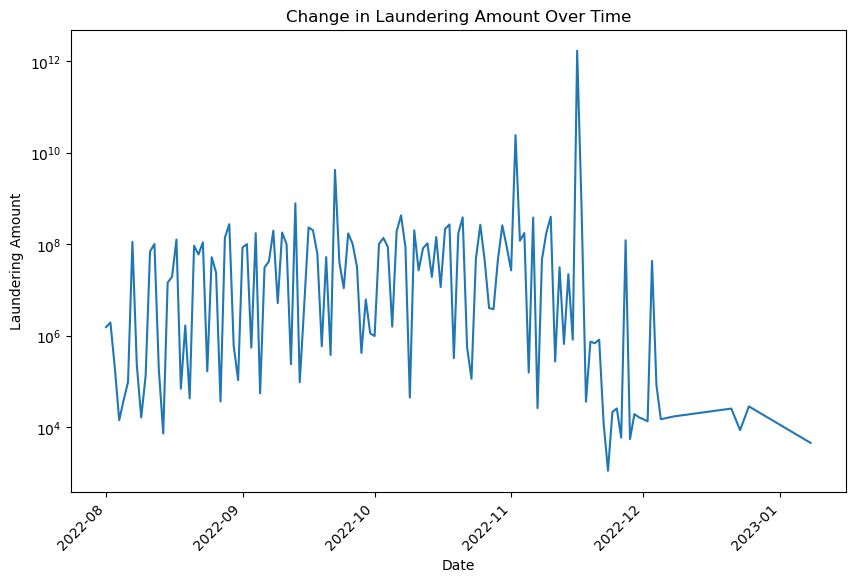

In [8]:
# Convert datatype
sample_df = sample_df.withColumn("timestamp", F.to_timestamp("timestamp", 'yyyy/MM/dd HH:mm'))
sample_laundry_df = sample_df.where(sample_df['is_laundering'] == 1)

# Calculate the laundering amount
laundering_amount_by_timestamp = sample_laundry_df \
    .groupBy(sample_laundry_df['timestamp'].cast('date').alias('date')) \
    .agg({'amount_received': 'sum'}) \
    .withColumnRenamed('sum(amount_received)', 'laundering_amount')
# Sort Values
sorted_transactions = laundering_amount_by_timestamp.orderBy(F.col('date')).toPandas()

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(sorted_transactions['date'], sorted_transactions['laundering_amount'], linestyle='-')
plt.title('Change in Laundering Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Laundering Amount')
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.show()

**Answer:** The 'Laundering Amount Over Time' chart displays data points on a line graph, where each point represents the total amount laundered per day. These are plotted as dots connected by lines to illustrate the trend over time. The chart visually represents the daily changes in the total amount involved in laundering activities within the sampled dataset.

### **Question2:** What is the Proportional Distribution of Different Money Laundering Patterns Within Transaction Cycles?

In [33]:
# Count the transaction numbers per laundering type and cycle
laundry_id_pattern_counts = sample_laundry_df.groupBy("aml_type","id_pattern").agg(F.count("*").alias("num_transactions"))
# Get the average value
laundry_id_pattern_counts = laundry_id_pattern_counts.groupBy("aml_type").agg(F.mean("num_transactions").alias("num_transactions"))
laundry_id_pattern_counts_no_Null = laundry_id_pattern_counts.toPandas()
# Drop null values
laundry_id_pattern_counts_no_Null.dropna(inplace =True)
laundry_id_pattern_counts_no_Null

,aml_type,num_transactions
0,FAN-IN,1.133333
2,GATHER-SCATTER,1.215385
3,CYCLE,1.218182
4,FAN-OUT,1.144928
5,SCATTER-GATHER,1.244094
6,STACK,1.152000
7,BIPARTITE,1.127273
8,RANDOM,1.307692


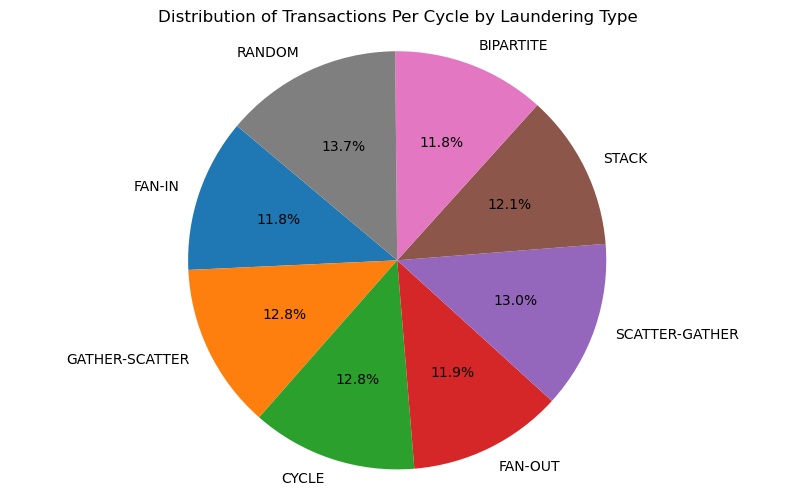

In [88]:
# Plot the Result
laundry_id_pattern_counts_no_Null['num_transactions'] = round(laundry_id_pattern_counts_no_Null['num_transactions'],2)
plt.figure(figsize=(10, 6))
plt.pie(
        laundry_id_pattern_counts_no_Null['num_transactions'],
        labels=laundry_id_pattern_counts_no_Null['aml_type'],
        autopct='%1.1f%%',
        startangle=140
)
plt.title('Distribution of Transactions Per Cycle by Laundering Type')
plt.axis('equal')
plt.show()

**Answer:** The pie chart presented above shows the distribution of transactions across different money laundering patterns within a cycle. Each segment's size reflects the proportion of transactions that fall under each laundering pattern type, with labels such as "STACK," "SCATTER-GATHER," "CYCLE," "FAN-IN," "FAN-OUT," "GATHER-SCATTER," "BIPARTITE," and "RANDOM." The presence of these labels helps in identifying the various methods of money laundering detected in the dataset.
It appears that the laundering pattern types are relatively evenly distributed in the sampled data, with no single type dominating the chart. This suggests that, within the dataset sampled, there is a diverse range of money laundering patterns employed, rather than a concentration on any particular method. It's an indication that the entities involved in money laundering are using a variety of techniques to conduct their illicit activities.

### **Question3:** What is the breakdown of transactions by currency and laundering type?

<Figure size 1000x600 with 0 Axes>

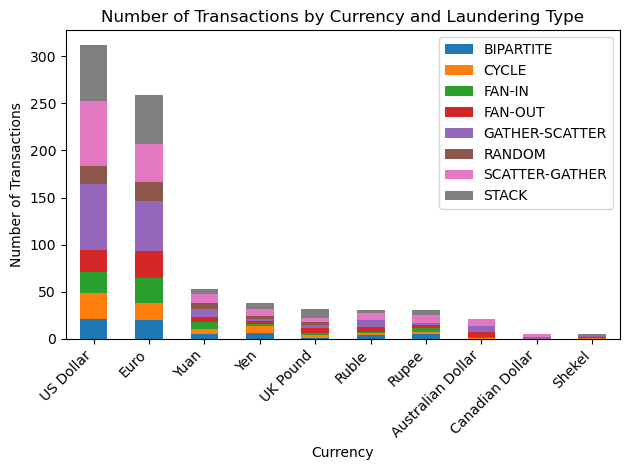

In [87]:
# Count the transaction numbers per laundering type and currency
currency_by_laun = sample_laundry_df.groupBy('payment_currency', 'aml_type').count().toPandas()
# Drop null values
currency_by_laun = currency_by_laun.dropna()
pivot_df = currency_by_laun.pivot(index='payment_currency', columns='aml_type', values='count').fillna(0)

# Sort Values
pivot_df['total'] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values(by='total', ascending=False)
pivot_df.drop(columns='total', inplace=True)

# Plot the result
plt.figure(figsize=(10, 6))
pivot_df.plot(kind='bar', stacked=True)
plt.title('Number of Transactions by Currency and Laundering Type')
plt.xlabel('Currency')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()  
plt.show()

**Answer:**  Based on the chart provided, it's evident that within laundering-related transactions, US Dollars and Euros are the predominant currencies. Remarkably, within these currencies, laundering types such as STACK, SCATTER-GATHER, and GATHER-SCATTER demonstrate substantial prevalence. Additionally, it can be observed that the laundering type SCATTER-GATHER appears in almost all currencies, highlighting its widespread occurrence. Therefore, emphasis on addressing these types of money laundering could be beneficial.

### **Question4:** What is the trend regarding at what time most money laundering transactions occur?

+----+-----+
|Hour|count|
+----+-----+
|   0|   40|
|   1|   32|
|   2|   36|
|   3|   38|
|   4|   38|
|   5|   67|
|   6|   44|
|   7|   48|
|   8|   58|
|   9|   53|
|  10|   56|
|  11|   69|
|  12|   60|
|  13|   84|
|  14|   68|
|  15|   74|
|  16|   66|
|  17|   65|
|  18|   51|
|  19|   60|
|  20|   34|
|  21|   35|
|  22|   39|
|  23|   25|
+----+-----+



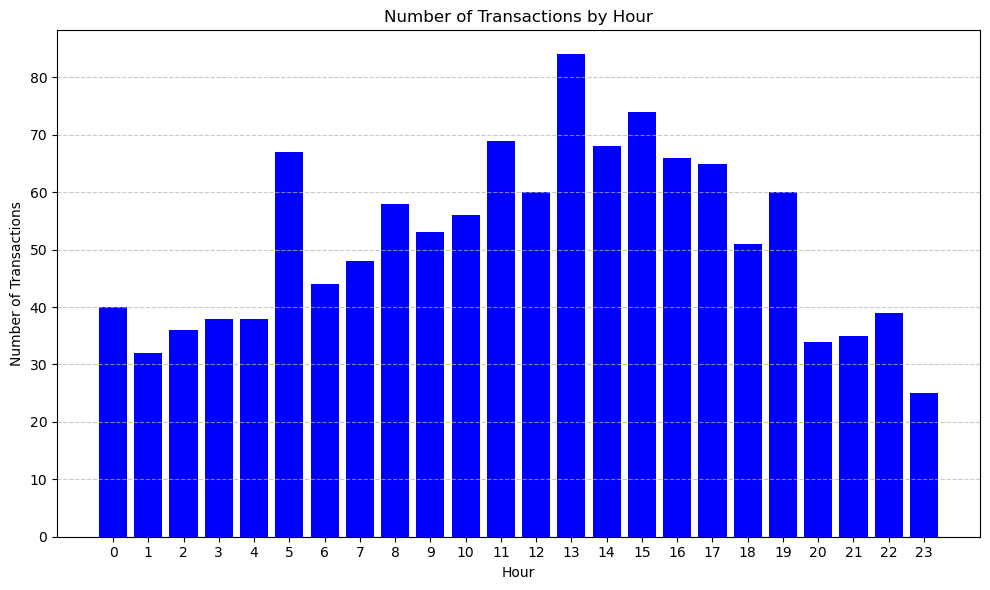

In [82]:
# Count the laundering transaction numbers per hour
hour_count = sample_laundry_df.groupBy(F.hour("timestamp").alias("Hour")).count().orderBy("Hour")
hour_count.show(24)
hour_count_pd = hour_count.toPandas()

# Plot the result
plt.figure(figsize=(10, 6))
plt.bar(hour_count_pd['Hour'], hour_count_pd['count'], color='b')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Hour')
plt.xticks(range(hour_count_pd['Hour'].min(), hour_count_pd['Hour'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Answer:** This graph shows the number of transactions for each hour of the day. The horizontal axis (x-axis) represents the 24 hours of the day. The vertical axis (y-axis) represents the number of transactions. From the graph, we can see that the highest number of money laundry transactions is around 13:00 (1 PM), while the hours late at night and early in the morning show fewer transactions, as shown by shorter bars. An interesting observation is that money laundering transactions reach their peak at 5 AM before reaching the next peak in the afternoon.

### **Question5:** What is the range of transaction volume for each currencies involved in laundering?

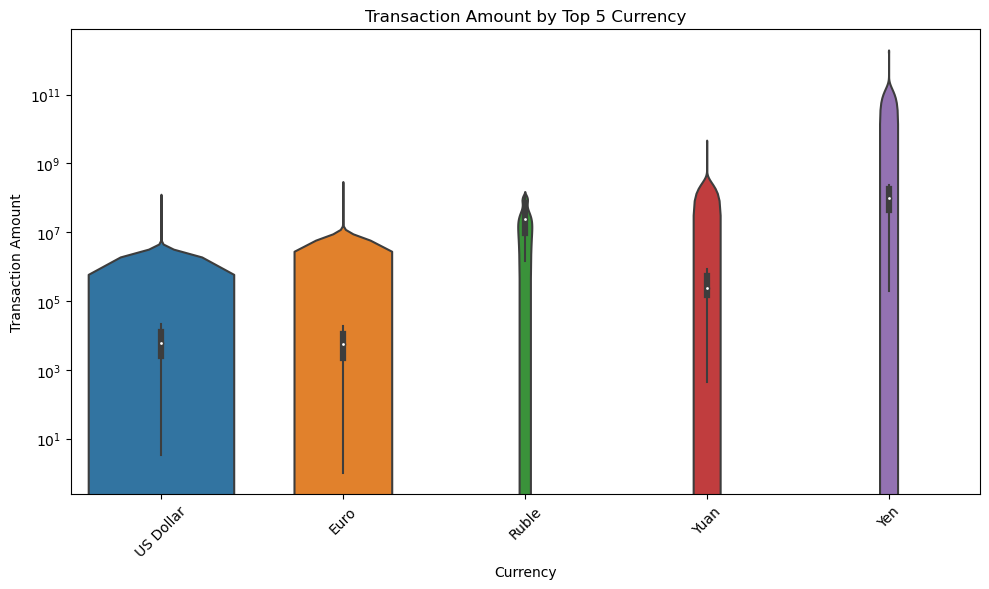

In [101]:
# Count the numbers per currency
currency_counts = sample_laundry_df.groupBy("payment_currency").count()
# Get the top5 currency
top_currencies = currency_counts.orderBy(col("count").desc()).limit(5)
top_sample_laundry_df = sample_laundry_df.join(
    top_currencies, on="payment_currency", how="inner")

# Convert to Pandas
top_sample_laundry_pd = top_sample_laundry_df.toPandas()

# Plot the result, from ChatGPT
plt.figure(figsize=(10, 6))
sns.violinplot(
    x="payment_currency",
    y="amount_received",
    scale="count",
    data=top_sample_laundry_pd)
plt.xticks(rotation=45)
plt.yscale('log')
plt.xlabel('Currency')
plt.ylabel('Transaction Amount')
plt.title('Transaction Amount by Top 5 Currency')
plt.tight_layout()
plt.show()

**Answer:** In the above graph, we have gathered data for the top 5 currencies involved in laundering activities, ranking them based on their transaction volume. The plotted currencies—US Dollar, Euro, Ruble, Yuan, and Yen offers insight into the distribution of transaction volumes within the dataset.
The width of each violin plot segment reflects the prevalence of each currency within the dataset. Notably, the US Dollar appears to have a broader spread compared to the other currencies. Conversely, the Ruble has the narrowest width, indicating its relatively minor presence in the laundering activity dataset. The Yen displays an average transaction volume exceeding 100 billion units. On the other hand, the US Dollar, despite its widespread presence, showcases an average transaction volume hovering around 100 million units. By analyzing the details of transaction volume and prevalence, this visualization provides valuable insights into the distribution of laundering activities among the top 5 currencies.

### **Question 6:** On which day of the week do fraudulent transactions peak, and what are the potential strategies to combat this?

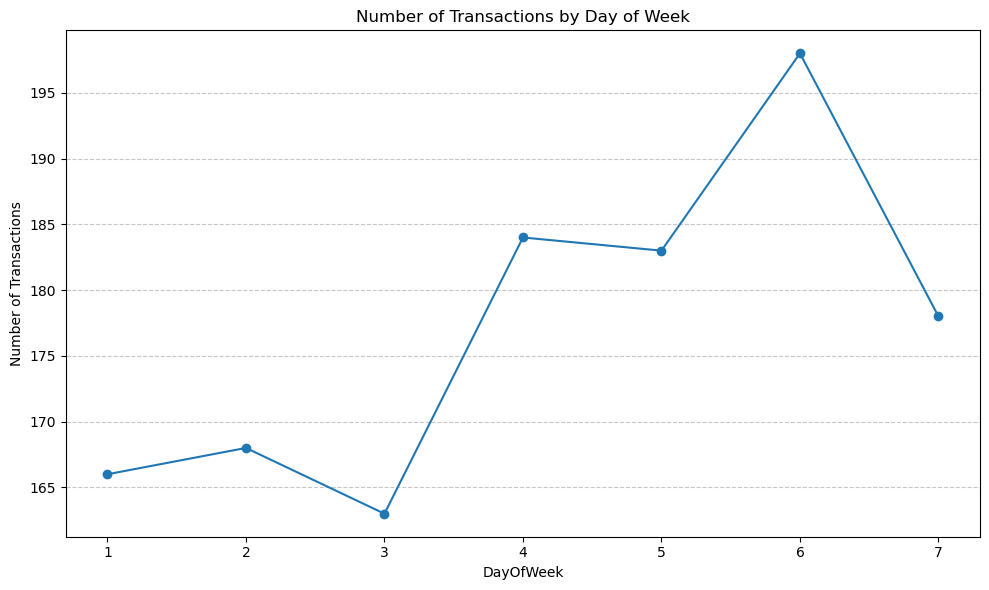

In [15]:
# Common period for laundry (by day of the week)
day_of_week_count = sample_laundry_df.groupBy(F.dayofweek("timestamp").alias("DayOfWeek")).count().orderBy("DayOfWeek")
day_of_week_count.show()
day_of_week_count_pd = day_of_week_count.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(day_of_week_count_pd['DayOfWeek'], day_of_week_count_pd['count'], marker='o', color='tab:blue', linestyle='-')
plt.xlabel('Day Of Week')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Day of Week')
plt.xticks(day_of_week_count_pd['DayOfWeek'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Answer:** The plot reveals a spike in fraudulent transactions on Saturdays. This trend could be attributed to potential lower vigilance due to weekend staffing. Addressing this might include enhanced monitoring with tools to detect fraud patterns, using anomaly detection to flag irregularities, ensuring sufficient weekend staff, implementing real-time analysis to intercept suspicious activities, and educating customers on fraud risks. Proactively adjusting strategies can help institutions safeguard against heightened weekend fraud risks.

### **Question 7:** What patterns can be observed in transactions throughout the day?

+----+-----------------+--------------------+
|Hour|Transaction_Count|      Average_Amount|
+----+-----------------+--------------------+
|   0|               40|  6.16196560034401E8|
|   1|               32|1.0569519006430026E7|
|   2|               36|    6600646.35160607|
|   3|               38|   9144812.472978193|
|   4|               38|  3048472.2444050713|
|   5|               67|  3229776.1316531105|
|   6|               44|   5270533.271522029|
|   7|               48|   6439537.083396469|
|   8|               58|1.0125827600649063E7|
|   9|               53|1.0410313359506864E7|
|  10|               56|   5274101.347583534|
|  11|               69|   7671857.446329798|
|  12|               60|1.5773022755872658E7|
|  13|               84|   3510073.342630793|
|  14|               68|   5022543.838609312|
|  15|               74|2.328545729052855...|
|  16|               66|   7360978.099884218|
|  17|               65|1.1355981356679946E7|
|  18|               51|   6242546

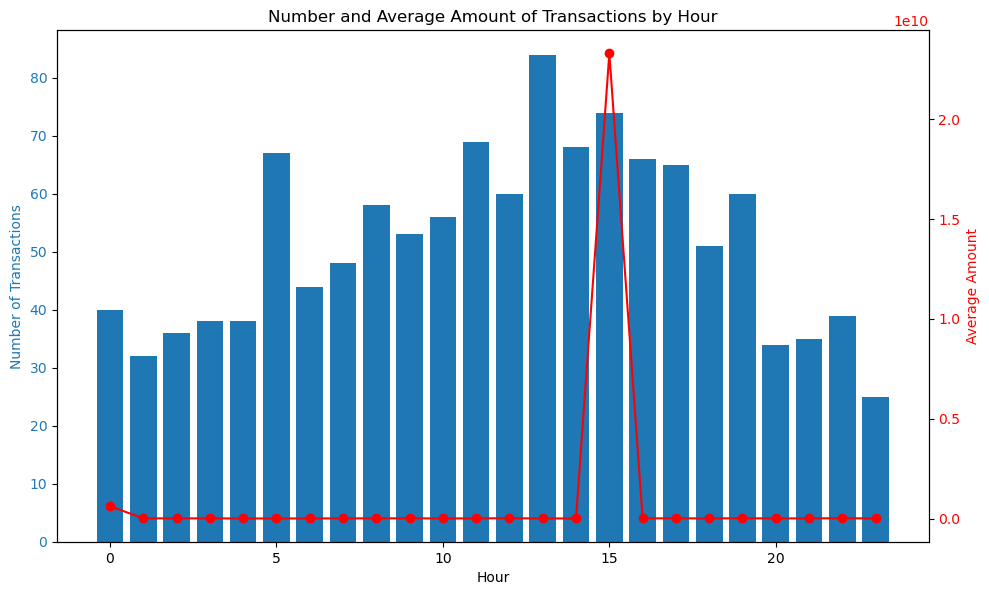

In [16]:
# Number and Average Amount of Transactions by Hour
transaction_stats_by_hour = sample_laundry_df.groupBy(F.hour("timestamp").alias("Hour")) \
    .agg(
        F.count("amount_received").alias("Transaction_Count"),
        F.avg("amount_received").alias("Average_Amount")
    ).orderBy("Hour")

transaction_stats_by_hour.show(24)
transaction_stats_by_hour_pd = transaction_stats_by_hour.toPandas()

fig, ax1 = plt.subplots(figsize=(10, 6))

# Number of transactions
ax1.set_xlabel('Hour')
ax1.set_ylabel('Number of Transactions', color='tab:blue')
ax1.bar(transaction_stats_by_hour_pd['Hour'], transaction_stats_by_hour_pd['Transaction_Count'], color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Twin axis for the average amount
ax2 = ax1.twinx()
ax2.set_ylabel('Average Amount', color='r')
ax2.plot(transaction_stats_by_hour_pd['Hour'], transaction_stats_by_hour_pd['Average_Amount'], color='r', marker='o')
ax2.tick_params(axis='y', labelcolor='r')
fig.tight_layout()
plt.title('Number and Average Amount of Transactions by Hour')
plt.show()

**Answer:** The chart shows two key transaction trends throughout the day. There's a significant rise in the number of transactions around noon, possibly aligning with peak business hours. Meanwhile, the average transaction value remains consistent, except for a pronounced increase at 3 PM, which does not coincide with the peak number of transactions. This discrepancy at 3 PM could be significant for fraud detection, signaling unusual, high-value transactions. This exceptional spike at an off-peak hour might necessitate further investigation for potential fraud or money laundering.

### **Question 8:** Distribution of fraud and non fraud transactions across different currencies

In [33]:
# Count the number of fraudulent transactions
num_fraudulent = sample_df.filter(sample_df.is_laundering == 1).count()

# Count the number of non-fraudulent transactions
num_non_fraudulent = sample_df.filter(sample_df.is_laundering == 0).count()

print("Number of fraudulent transactions:", num_fraudulent)
print("Number of non-fraudulent transactions:", num_non_fraudulent)


Number of fraudulent transactions: 1133
Number of non-fraudulent transactions: 896579


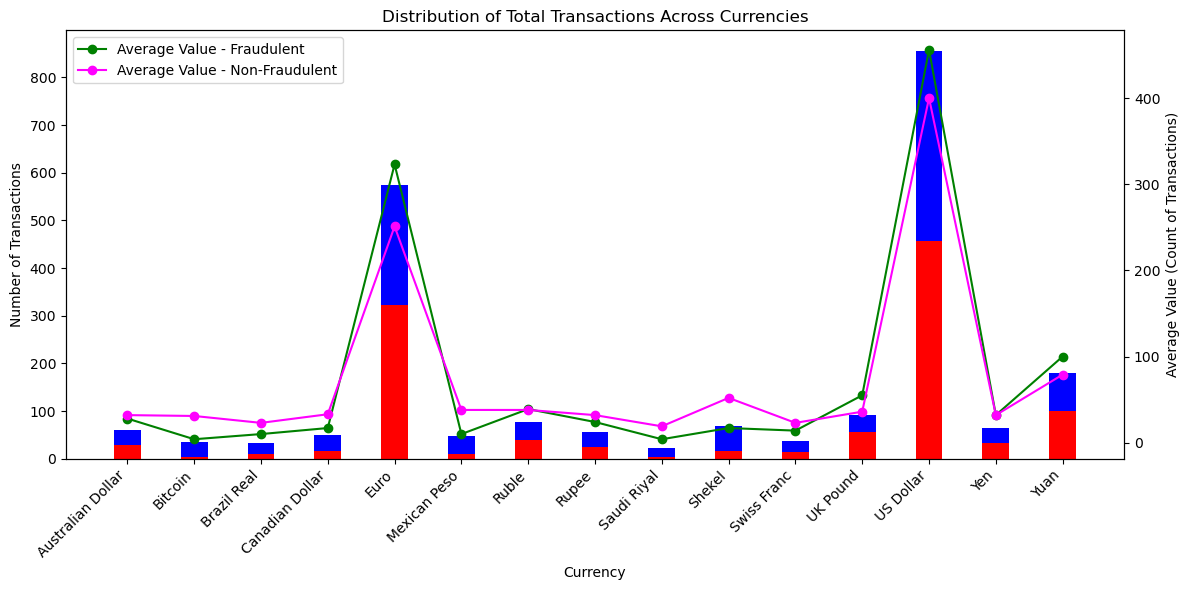

In [ ]:
from pyspark.sql.functions import rand

# Sample a subset of non-fraudulent transactions
non_fraudulent_sampled = sample_df.filter(sample_df.is_laundering == 0).sample(False, 1133 / 896579, seed=42)

# Combine the sampled non-fraudulent transactions with the fraudulent transactions
balanced_sample_df = non_fraudulent_sampled.union(sample_df.filter(sample_df.is_laundering == 1))

# Aggregate the count of transactions for each currency and is_laundering flag
transactions_agg = balanced_sample_df.groupBy("receiving_currency", "is_laundering").count()

# Convert PySpark DataFrame to Pandas DataFrame for visualization
transactions_pd = transactions_agg.toPandas()

# Pivot the DataFrame to separate fraudulent and non-fraudulent transactions
pivot_transactions = transactions_pd.pivot(index='receiving_currency', columns='is_laundering', values='count').fillna(0)

# Plot the stacked bar chart for fraudulent and non-fraudulent transactions
plt.figure(figsize=(12, 6))
bar_width = 0.4
fraudulent_bar = plt.bar(pivot_transactions.index, pivot_transactions[1], color='red', label='Fraudulent', width=bar_width)
non_fraudulent_bar = plt.bar(pivot_transactions.index, pivot_transactions[0], color='blue', label='Non-Fraudulent', width=bar_width, bottom=pivot_transactions[1])
plt.title("Distribution of Total Transactions Across Currencies")
plt.xlabel("Currency")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45, ha='right')

# Calculate and plot the average value of transactions for both fraudulent and non-fraudulent transactions
# Aggregate the count of transactions for each currency
avg_transactions_agg = balanced_sample_df.groupBy("receiving_currency", "is_laundering").count()

# Convert PySpark DataFrame to Pandas DataFrame for visualization
avg_transactions_pd = avg_transactions_agg.toPandas()

# Separate fraudulent and non-fraudulent transactions
avg_pivot_transactions = avg_transactions_pd.pivot(index='receiving_currency', columns='is_laundering', values='count').fillna(0)

# Twin axis for the average value
ax2 = plt.gca().twinx()

# Plot average values for fraudulent and non-fraudulent transactions
ax2.plot(avg_pivot_transactions.index, avg_pivot_transactions[1], color='green', marker='o', linestyle='-', label='Average Value - Fraudulent')
ax2.plot(avg_pivot_transactions.index, avg_pivot_transactions[0], color='magenta', marker='o', linestyle='-', label='Average Value - Non-Fraudulent')
ax2.set_ylabel("Average Value (Count of Transactions)")
ax2.legend(loc='upper left')

plt.legend()

plt.tight_layout()
plt.show()

**Answer:** The graph distinguishes between fraudulent transactions (depicted in red) and non-fraudulent transactions (depicted in blue). It's notable that the number of transactions is evenly spread out across currencies, with USD and Euro showing the highest transaction volumes. Despite the even distribution, there's a significant spike in the average transaction value for both USD and Euro. This spike could indicate that fraudulent activities are more prevalent in transactions involving these currencies, possibly due to their widespread use and higher values, making them attractive targets for fraudulent activities. Further investigation into the nature of these transactions could provide insights into why USD and Euro transactions are particularly susceptible to fraudulent activities.

### **Question 9: How do perpetrators of money laundering typically change currency and payment format?**

In [251]:
result = spark.sql("""
SELECT * 
FROM df_pattern 
WHERE id_pattern IN (
    SELECT id_pattern
    FROM df_pattern 
    WHERE aml_type = 'RANDOM'
    GROUP BY id_pattern
    ORDER BY COUNT(id_pattern) DESC
    LIMIT 1
)
ORDER BY timestamp
""")
result.show(10)

result = result.toPandas()

+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+--------+----------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|
+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+--------+----------+
|2022/09/04 17:07|     001216|     805C35560|           000|        801B745B0|         717.53|         US Dollar|     717.53|       US Dollar|           ACH|            1|  RANDOM|      5815|
|2022/09/09 16:55|        000|     801B745B0|        022483|        8046FF4F0|         573.84|              Euro|     573.84|            Euro|           ACH|            1|  RANDOM|      5815|
|2022/09/11 13:56|     022483|     8046F

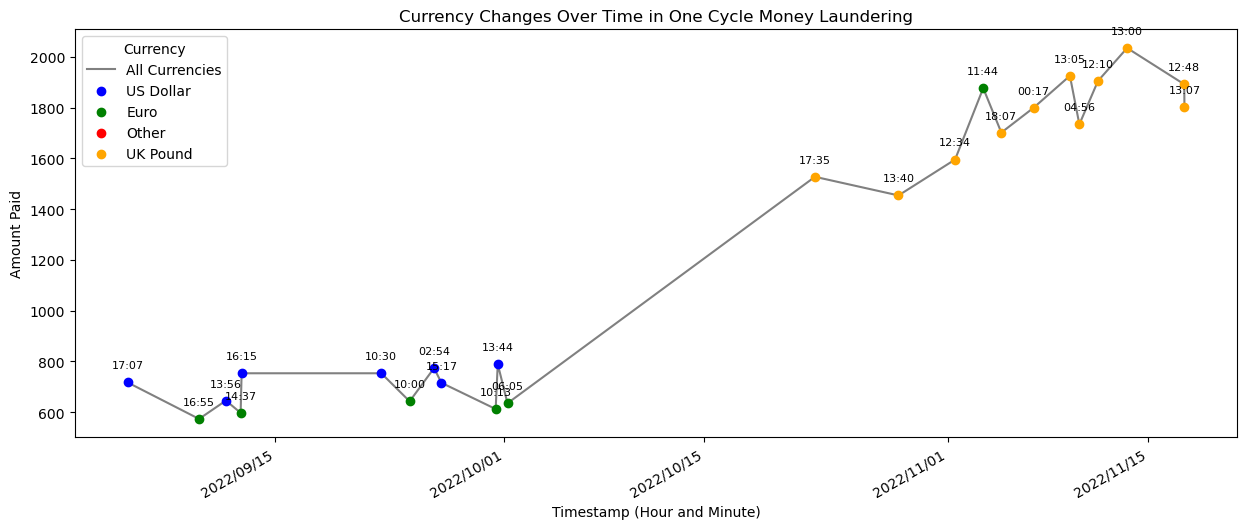

In [252]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

result['timestamp'] = pd.to_datetime(result['timestamp'])
result_sorted = result.sort_values('timestamp')

# create the graph
fig, ax = plt.subplots(figsize=(15, 6))

# set the color of each currency
colors = {'US Dollar': 'blue', 'Euro': 'green', 'Other': 'red', 'UK Pound': 'orange'}

# plot the currency into the graph
ax.plot(result_sorted['timestamp'], result_sorted['amount_paid'], color='grey', linestyle='-', label='All Currencies', zorder=1)

for currency, color in colors.items():
    currency_data = result_sorted[result_sorted['payment_currency'] == currency]

    ax.scatter(currency_data['timestamp'], currency_data['amount_paid'], c=color, label=currency, zorder=2)

for idx, row in result_sorted.iterrows():
    ax.annotate(row['timestamp'].strftime('%H:%M'), 
                (mdates.date2num(row['timestamp']), row['amount_paid']), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, zorder=3)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))

plt.gcf().autofmt_xdate()

ax.set_xlabel('Timestamp (Hour and Minute)')
ax.set_ylabel('Amount Paid')
ax.set_title('Currency Changes Over Time in One Cycle Money Laundering')
ax.legend(title='Currency')

plt.show()

**Answer**: From the graph, we can see the visualization of one example of the longest transaction chain in one cycle, which consists of 24 transactions in one cycle with the "Random" Money Laundering type. From the graph, we observe that the transaction perpetrator carried out transactions in cross-currency several times, namely in US Dollar, Euro, and UK Pound, to obscure them from the detection of that suspicious transaction.

### **Question 10:** Interrelationships between different transaction features within laundering networks

In [10]:
df_pattern.createOrReplaceTempView("df_pattern")

In [15]:
## Group by id pattern to calculate total and fetch all records for "RANDOM"
result = spark.sql("""
SELECT * 
FROM df_pattern 
WHERE id_pattern IN (
    SELECT id_pattern
    FROM df_pattern 
    WHERE aml_type = 'RANDOM'
    GROUP BY id_pattern
    ORDER BY COUNT(id_pattern)
    LIMIT 1
)
ORDER BY timestamp
""")

#Show DF
result.show(10)

# Convert DataFrame to Pandas
result = result.toPandas()

+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+--------+----------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering|aml_type|id_pattern|
+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+--------+----------+
|2022/08/25 03:57|    0243028|     823D26E50|       0231993|        81152B1C0|       837956.7|         US Dollar|   837956.7|       US Dollar|           ACH|            1|  RANDOM|      4032|
|2022/10/12 06:42|    0099927|     824EFD540|       0099479|        824EFD4F0|        4666.66|          UK Pound|    4666.66|        UK Pound|           ACH|            1|   CYCLE|      4032|
|2022/10/16 10:57|    0099479|     824EF

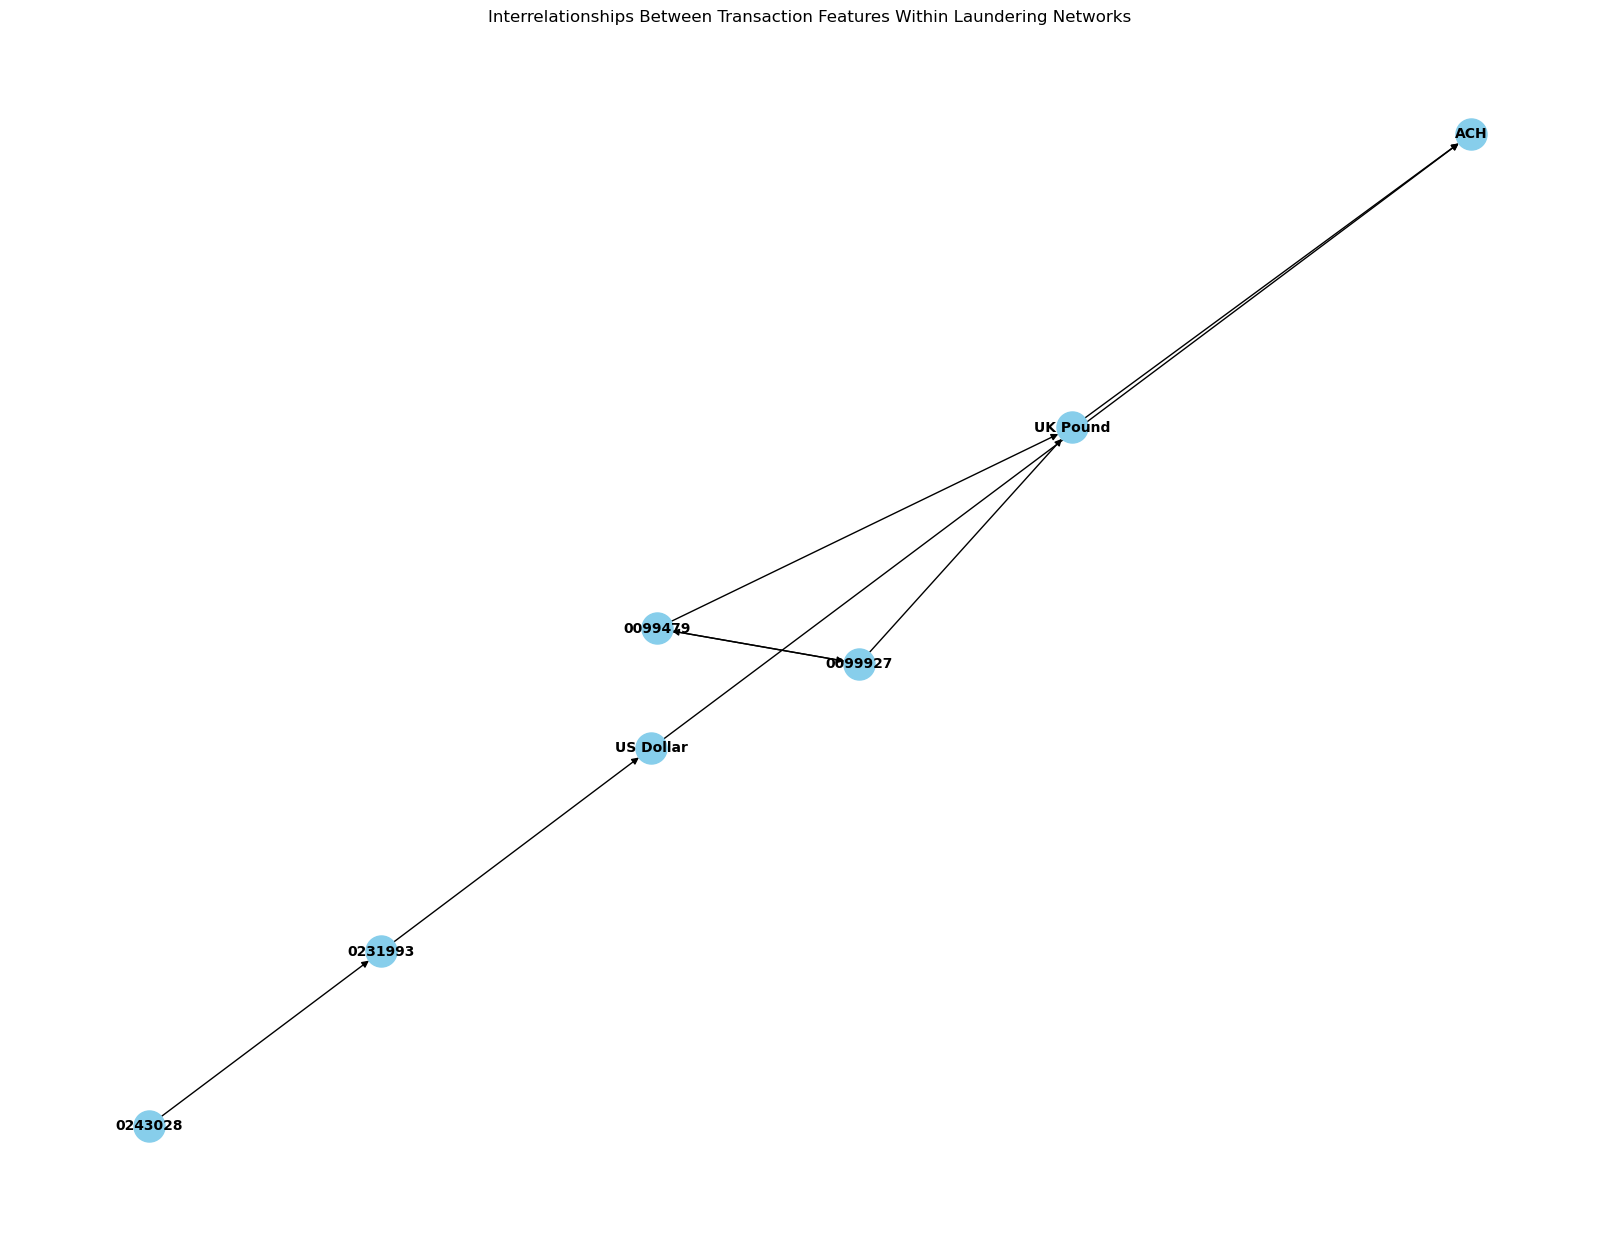

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

# Sample DataFrame
#sample_df_sample = sample_df.sample(False, 0.005, seed=42)

# Identify relationships between transaction features
transaction_features = result[["sender_bank", "recipient_bank", "receiving_currency", "payment_format"]]

# Convert DataFrame to Pandas
#transaction_features_pd = transaction_features.toPandas()

# Network graph using NetworkX
G = nx.DiGraph()

# Add edges between transaction features
for index, row in transaction_features.iterrows():
    sender_bank = row['sender_bank']
    recipient_bank = row['recipient_bank']
    receiving_currency = row['receiving_currency']
    payment_format = row['payment_format']
    
    G.add_edge(sender_bank, recipient_bank)
    G.add_edge(recipient_bank, receiving_currency)
    G.add_edge(receiving_currency, payment_format)

# Plot the network graph
plt.figure(figsize=(16, 12))  # Increase the figure size
pos = nx.spring_layout(G, k=0.1, iterations=100)  # Adjust layout parameters
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold", arrows=True, arrowsize=10)
plt.title("Interrelationships Between Transaction Features Within Laundering Networks")
plt.show()

**Answer:** The network graph offers a visual representation of the intricate relationships between sender and receiver banks, along with the associated currency and transaction types utilized in each transaction. In this specific depiction, a sample of rows from the dataset is employed to unveil underlying patterns. As observed in the graph, transactions originating from bank 0243028 are directed towards bank 0231993, denominated in USD, followed by subsequent transfers to bank codes 009927 and 0099479, eventually being converted into UK Pound. Notably, the entire sequence of transactions is facilitated through the ACH transaction type, showcasing a clear flow of funds and currency conversions along the banking network. This visualization aids in understanding the complex web of financial transactions and highlights the pathways through which funds are transferred and currencies are exchanged among various banks.

### **Question 11:** Evolution of laundering patterns over time

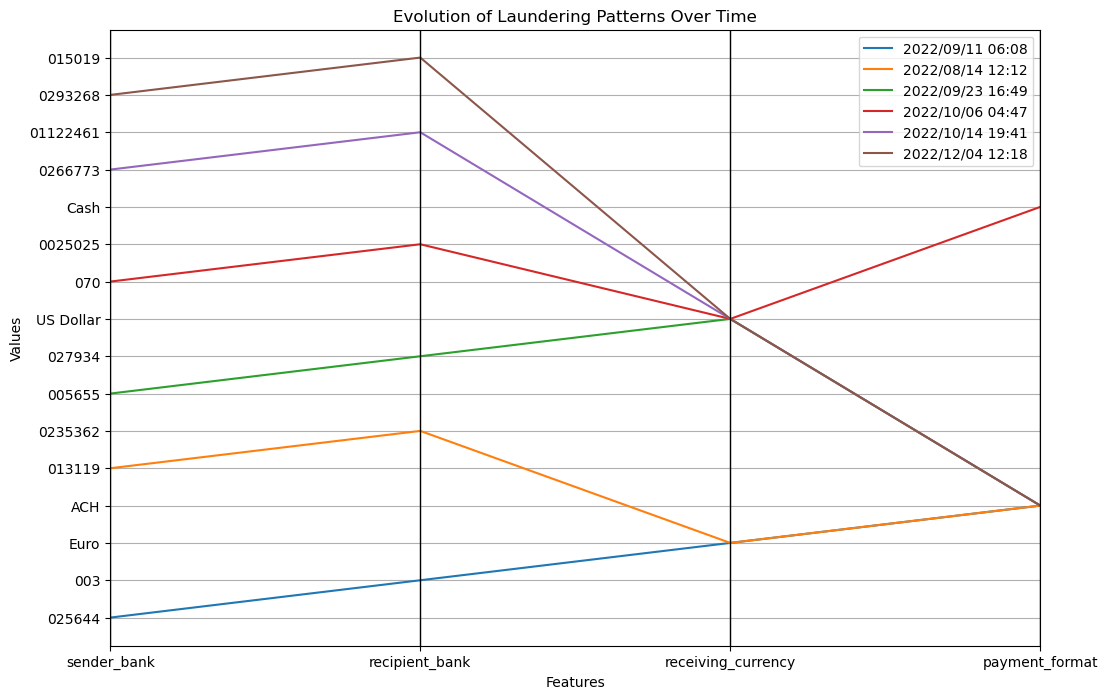

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample the entire DataFrame
sample_df_sample = sample_df.sample(False, 0.005, seed=42)

# Preprocess the data to identify laundering patterns and their evolution over time
laundering_patterns = sample_df_sample.filter(sample_df_sample.is_laundering == 1).select(
    "timestamp", "sender_bank", "recipient_bank", "receiving_currency", "payment_format"
)

# Convert PySpark DataFrame to Pandas DataFrame for visualization
laundering_patterns_pd = laundering_patterns.toPandas()

# Get unique timestamps
unique_timestamps = laundering_patterns_pd['timestamp'].unique()

# Define unique colors for each timestamp using a brighter and more contrasting colormap
color_map = {
    timestamp: plt.cm.tab10(i % 10)
    for i, timestamp in enumerate(unique_timestamps)
}

# Plot the parallel coordinates plot
plt.figure(figsize=(12, 8))
pd.plotting.parallel_coordinates(laundering_patterns_pd, class_column='timestamp', color=[color_map[timestamp] for timestamp in laundering_patterns_pd['timestamp']])
plt.title("Evolution of Laundering Patterns Over Time")
plt.xlabel("Features")
plt.ylabel("Values")
plt.legend(loc='upper right')
plt.show()


**Answer:** The graph provides a comprehensive visualization of transaction dynamics across seven distinct timestamps within the dataset, capturing the evolution of each transaction over time. Various transaction details, including sender and receiver bank information, receiving currency, and payment format, are meticulously plotted along different axes. Each timeline is represented by uniquely colored lines, showcasing the pattern observed for transactions at each timestamp. For instance, a notable case illustrated in the graph involves a transaction initiated from sender bank 013119, which is received by bank 02335362. This transaction occurs in the ACH format, with the currency involved being EURO. Such visualizations offer valuable insights into the sequential flow of transactions, enabling analysts to discern patterns, identify trends, and gain a deeper understanding of the transactional behavior within the dataset.

### **Question 12:** Which money laundering typology involves the most bank accounts, and what does this suggest about the complexity of these schemes?

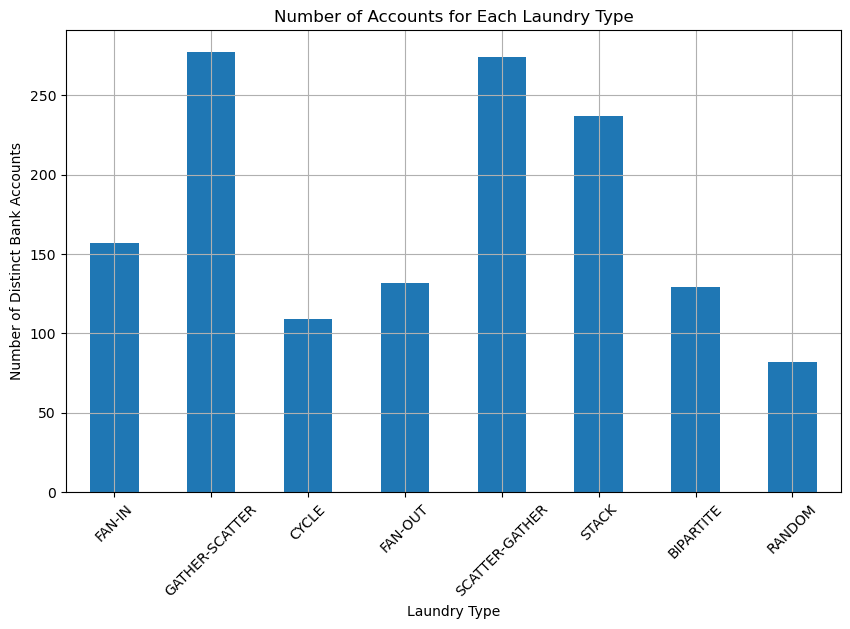

In [52]:
# Group transactions by laundry type and count the number of accounts for each laundry type
laundry_type_counts = sample_laundry_df.groupBy("aml_type").agg(F.countDistinct("sender_account").alias("num_accounts")).filter(col("aml_type").isNotNull())
laundry_type_counts_pd = laundry_type_counts.toPandas()

# Plotting
laundry_type_counts_pd.plot(kind='bar', x='aml_type', y='num_accounts', figsize=(10, 6))
plt.title('Number of Bank Accounts for Each Laundry Type')
plt.xlabel('Laundry Type')
plt.ylabel('Number of Distinct Bank Accounts')
plt.xticks(rotation=45)
plt.legend().remove()
plt.grid()
plt.show()

**Answer:** The bar chart demonstrates that the "Scatter-Gather" and "Gather-Scatter" typologies involve the most distinct bank accounts compared to other types. This suggests that these methods of money laundering are more complex and possibly more organized, as they involve the distribution and collection of funds across many accounts. The complexity of these schemes may make them harder to detect and could indicate a more widespread network of collusion. It is important for financial institutions to pay special attention to these patterns in transactions to effectively combat money laundering.

### **Question 13:** What does the variation in cycle duration reveal about different money laundering typologies?

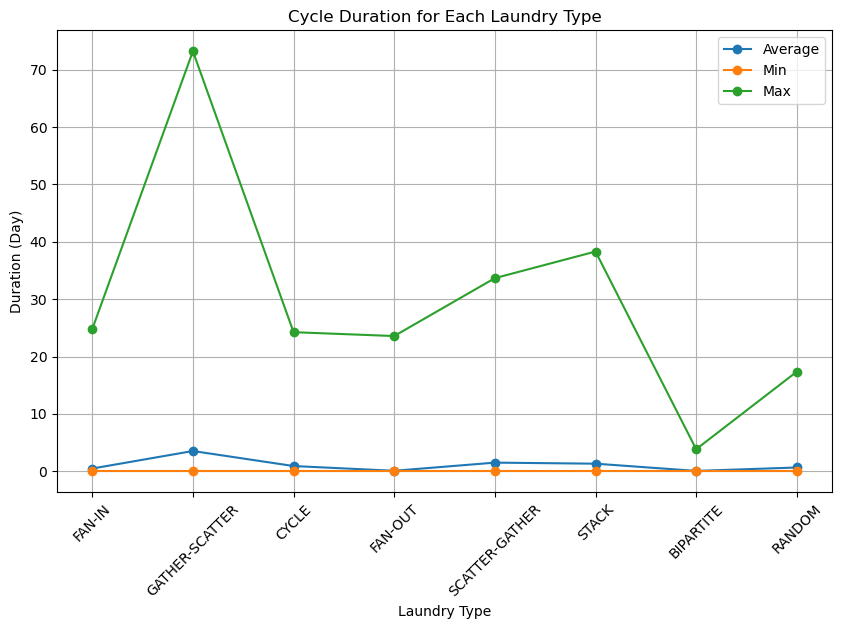

In [66]:
# Timestamp partition
window_spec_cycle = Window.partitionBy("aml_type", "id_pattern").orderBy("timestamp")

# Cycle duration for each cycle and laundry type
durations_by_cycle = sample_laundry_df.withColumn("start_time", F.first("timestamp").over(window_spec_cycle)) \
                                    .withColumn("end_time", F.last("timestamp").over(window_spec_cycle)) \
                                    .withColumn("cycle_duration", (F.unix_timestamp("end_time") - F.unix_timestamp("start_time")) / 86400) \
                                    .filter(F.col("aml_type").isNotNull())

# Average, min, and max cycle duration
average_duration = durations_by_cycle.groupBy("aml_type").agg(F.avg("cycle_duration").alias("average_cycle_duration"))
min_duration = durations_by_cycle.groupBy("aml_type").agg(F.min("cycle_duration").alias("min_cycle_duration"))
max_duration = durations_by_cycle.groupBy("aml_type").agg(F.max("cycle_duration").alias("max_cycle_duration"))

cycle_durations = average_duration.join(min_duration, "aml_type").join(max_duration, "aml_type")
cycle_durations_pd = cycle_durations.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cycle_durations_pd["aml_type"], cycle_durations_pd["average_cycle_duration"], marker='o', linestyle='-', label='Average')
plt.plot(cycle_durations_pd["aml_type"], cycle_durations_pd["min_cycle_duration"], marker='o', linestyle='-', label='Min')
plt.plot(cycle_durations_pd["aml_type"], cycle_durations_pd["max_cycle_duration"], marker='o', linestyle='-', label='Max')
plt.title('Cycle Duration for Each Laundry Type')
plt.xlabel('Laundry Type')
plt.ylabel('Duration (Day)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

**Answer:** The graph presents the average, minimum, and maximum duration of money laundering cycles for various typologies. The "Gather-Scatter" typology shows a significant variation, with cycle durations ranging from a few days to over two months, suggesting highly irregular patterns. This variability could indicate the use of sophisticated techniques designed to evade detection. In contrast, typologies like "Fan-in" and "Fan-out" display shorter and more consistent cycle durations, potentially reflecting simpler or more straightforward methods. The broad range in cycle durations for certain typologies underlines the need for dynamic monitoring systems that can adapt to the diverse timings of these illicit activities.

### **Question 14:** How do different money laundering typologies distribute across various transaction amount ranges?

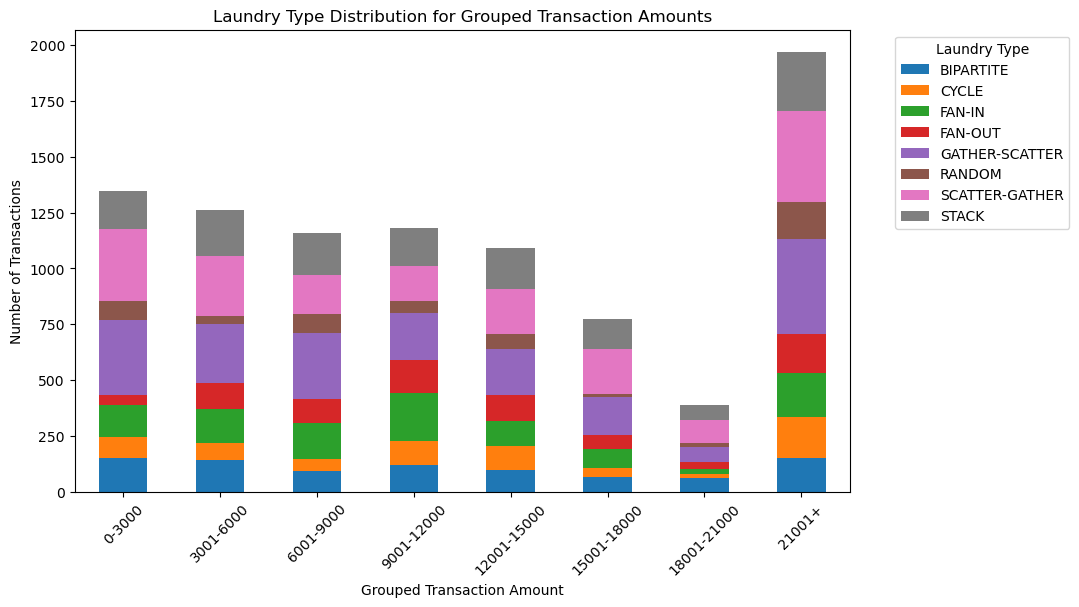

In [8]:
# Divide the transaction amount into bins
bins = [0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, float('inf')]
bin_labels = ['0-3000', '3001-6000', '6001-9000', '9001-12000', '12001-15000', '15001-18000', '18001-21000', '21001+']
sample_laundry_df = sample_laundry_df.withColumn("amount_bin", 
    when((col("amount_paid") >= 0) & (col("amount_paid") < 3000), "0-3000")
    .when((col("amount_paid") >= 3000) & (col("amount_paid") < 6000), "3001-6000")
    .when((col("amount_paid") >= 6000) & (col("amount_paid") < 9000), "6001-9000")
    .when((col("amount_paid") >= 9000) & (col("amount_paid") < 12000), "9001-12000")
    .when((col("amount_paid") >= 12000) & (col("amount_paid") < 15000), "12001-15000")
    .when((col("amount_paid") >= 15000) & (col("amount_paid") < 18000), "15001-18000")
    .when((col("amount_paid") >= 18000) & (col("amount_paid") < 21000), "18001-21000")
    .otherwise("21001+")
)

# Group the transactions
bin_laundry_type = sample_laundry_df.filter(col("aml_type").isNotNull()) \
    .groupBy("amount_bin", "aml_type").count().orderBy("amount_bin", "aml_type")
bin_laundry_type_pivot = bin_laundry_type.groupBy("amount_bin").pivot("aml_type").agg(first("count")).fillna(0)
bin_laundry_type_pivot_pd = bin_laundry_type_pivot.toPandas()

# Let the order to be the same as bin_labels
bin_laundry_type_pivot_pd['amount_bin'] = pd.Categorical(bin_laundry_type_pivot_pd['amount_bin'], categories=bin_labels, ordered=True)
bin_laundry_type_pivot_pd = bin_laundry_type_pivot_pd.sort_values('amount_bin')

# Plotting
bin_laundry_type_pivot_pd.plot(kind='bar', x='amount_bin', stacked=True, figsize=(10, 6))
plt.title('Laundry Type Distribution for Grouped Transaction Amounts')
plt.xlabel('Grouped Transaction Amount')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.legend(title='Laundry Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Answer:** The chart demonstrates a prevalence of smaller transactions within the '$0-$3000' range across various laundering methods, likely a strategy to evade detection by staying under the radar of regulatory thresholds. Typically, as the transaction value increases, the occurrence of transactions tends to decrease due to heightened visibility and risk. However, there is a notable increase in transactions within the '$21001+' bracket, implying that for substantial sums, launderers may opt for significantly higher amounts, possibly to optimize the laundering process or to accommodate the volume of illicit funds. This spike at high transaction levels, especially in "Scatter-Gather" and "Stack" methods, suggests a preference for these typologies when handling large amounts of money. The data underscores the importance of thorough monitoring across all transaction levels, tailored to the nuances of different laundering techniques.

### **Question 15: What is the distribution of Cross-Currency Transaction among the Money Laundering transaction?**

+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+---------+----------+----------------+
|       timestamp|sender_bank|sender_account|recipient_bank|recipient_account|amount_received|receiving_currency|amount_paid|payment_currency|payment_format|is_laundering| aml_type|id_pattern|   currency_pair|
+----------------+-----------+--------------+--------------+-----------------+---------------+------------------+-----------+----------------+--------------+-------------+---------+----------+----------------+
|2022/08/01 06:11|      02310|     800279EA0|         01213|        800509260|        8707.67|              Euro|    8707.67|            Euro|           ACH|            1|BIPARTITE|       006|       Euro-Yuan|
|2022/08/02 19:32|      00867|     80062BE20|           021|        8006A5050|       118150.6|              Yuan|   118150.6|            Yuan|           ACH|   

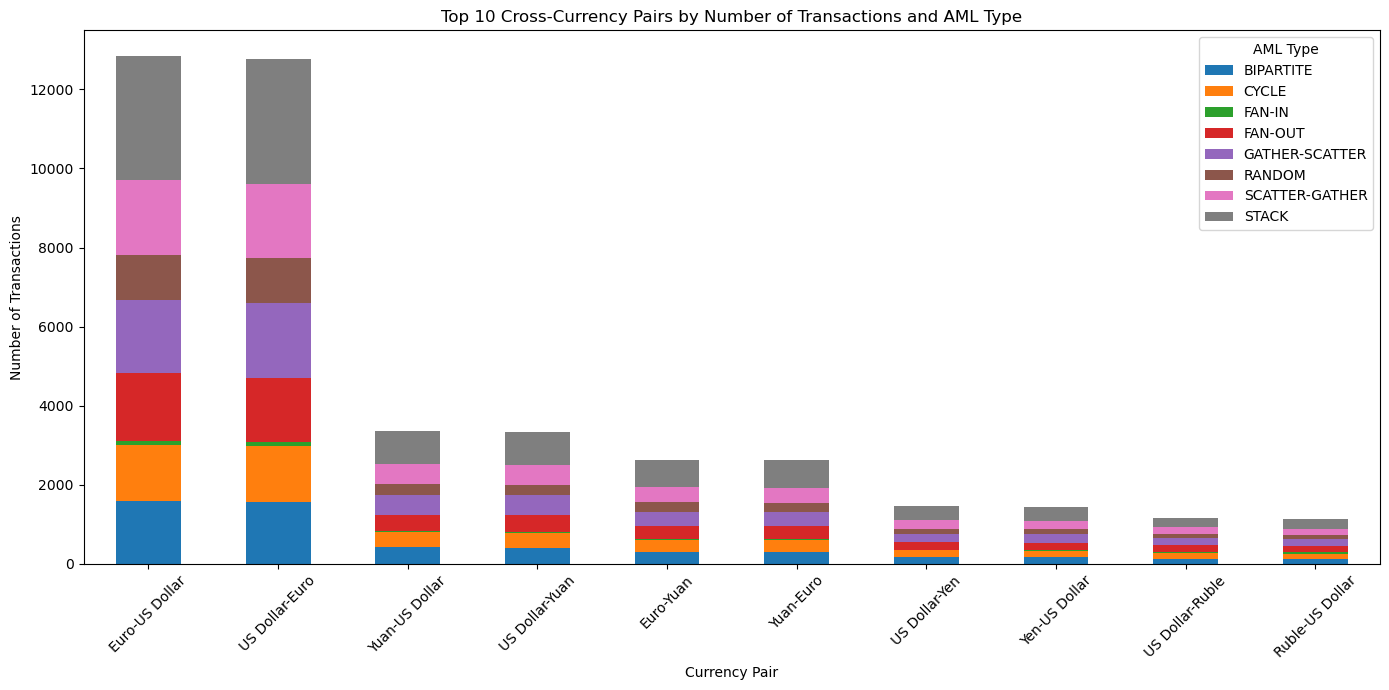

In [51]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Window function
windowSpec = Window.partitionBy("id_pattern").orderBy("timestamp")

# Chech the cross-currency pair in the sampe cycle
result_with_pair = df_pattern.withColumn(
    "next_payment_currency",
    F.lead("payment_currency").over(windowSpec)
).withColumn(
    "next_id_pattern",
    F.lead("id_pattern").over(windowSpec)
).withColumn(
    "currency_pair",
    F.when(
        (F.col("id_pattern") == F.col("next_id_pattern")) &  
        (F.col("payment_currency") != F.col("next_payment_currency")),  
        F.concat_ws("-", F.col("receiving_currency"), F.col("next_payment_currency"))
    )
)

result_with_pair = result_with_pair.filter(F.col("currency_pair").isNotNull())  

result_with_pair.select(
    "timestamp", "sender_bank", "sender_account", "recipient_bank", 
    "recipient_account", "amount_received", "receiving_currency", 
    "amount_paid", "payment_currency", "payment_format", "is_laundering", 
    "aml_type", "id_pattern", "currency_pair"
).show(30)

from pyspark.sql.functions import col

agg_result = result_with_pair.groupBy("currency_pair", "aml_type").count()

sum_count_by_pair = agg_result.groupBy("currency_pair").agg(F.sum("count").alias("total_transactions"))

top_10_pairs = sum_count_by_pair.orderBy(col("total_transactions").desc()).limit(10)

top_10_agg_result = agg_result.join(top_10_pairs, "currency_pair").select("currency_pair", "aml_type", "count")

top_10_agg_result_pd = top_10_agg_result.toPandas()

pivot_df = top_10_agg_result_pd.pivot(index='currency_pair', columns='aml_type', values='count').fillna(0)

pivot_df["total"] = pivot_df.sum(axis=1)
pivot_df = pivot_df.sort_values("total", ascending=False).drop("total", axis=1)

pivot_df.plot(kind='bar', stacked=True, figsize=(14, 7))

plt.xlabel('Currency Pair')
plt.ylabel('Number of Transactions')
plt.title('Top 10 Cross-Currency Pairs by Number of Transactions and AML Type')
plt.xticks(rotation=45)
plt.legend(title='AML Type')

plt.tight_layout()
plt.show()


**Answer:** Based on the graph, we can see that the most common cross-currency transaction in the transactions is Euro-US Dollar, followed by Yen-US Dollar, Euro-Yuan, US Dollar-Yen, and other currency pairs. Of these cross-currency transactions, the most prevalent money laundering method is STACK. This could be because STACK money laundering type typically involves multiple layers of transactions to further obscure the source of funds and changing currencies will adds another layer of complexity for the stack to the laundering process, making it harder to follow the money trail.

## Machine Learning techniques for Enhanced Detection of Money Laundering Activities

In this section, we deploy machine learning to scrutinize extensive transaction data for signs of money laundering. Our process incorporates logistic regression and utilizes preprocessing techniques like one-hot encoding and vector assembly to effectively handle both categorical and numerical data. This strategy enhances our model's capability to identify complex patterns indicative of money laundering, focusing on improving the detection process within our financial datasets.

In [1]:
# Load sample dataset
sample_df = spark.read.parquet("gs://ba843-rajr/notebooks/jupyter/temp_data/sample_df_single_partition.parquet")

In [2]:
from sklearn.utils import resample
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
from sklearn.metrics import roc_auc_score

# Create new dataframe for machine learning
sample_df_ml = sample_df.toPandas()
# Resample the data to solve the imbalance issue
# Separate majority and minority classes
majority_class = sample_df_ml[sample_df_ml['is_laundering'] == 0]
minority_class = sample_df_ml[sample_df_ml['is_laundering'] == 1]

# Downsample majority class
majority_downsampled = resample(majority_class, 
                                replace=False,    # Sample without replacement
                                n_samples=len(minority_class) * 2,  # Match minority class size times 2
                                random_state=42)  # Reproducible results

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([majority_downsampled, minority_class])
# Check the result for downsampled data
downsampled_data['is_laundering'].value_counts()

0    2480
1    1240
Name: is_laundering, dtype: int64

In [ ]:
# Define categorical columns for one-hot encoding
categorical_cols = ['sender_account', 'recipient_account', 'payment_currency', 'payment_format']
# Define feature columns
feature_cols = ['amount_paid']

# Create stages for StringIndexer, this stage converts categorical string columns into numerical indices
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid='keep') for col in categorical_cols]

# Create stages for OneHotEncoder, each distinct index value in the categorical column is 
# represented by a binary vector where only one element is 1 and the rest are 0s
encoders = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_onehot") for col in categorical_cols]

# Define VectorAssembler, VectorAssembler takes a list of input columns 
# (numeric and one-hot encoded) and concatenates them into a single vector column
assembler = VectorAssembler(inputCols=feature_cols + [col + "_onehot" for col in categorical_cols], outputCol='features')

# Define Logistic Regression model
lr = LogisticRegression(labelCol='is_laundering', featuresCol='features')

# Create Pipeline
pipeline = Pipeline(stages= (indexers + encoders + [assembler, lr]))

# Split the dataset into training and testing sets
train_data, test_data = sample_df.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)


In [4]:
# Evaluate the model with Accuracy
evaluator = BinaryClassificationEvaluator(labelCol='is_laundering')
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

# Evaluate the model with AUC-ROC
evaluator = BinaryClassificationEvaluator(labelCol='is_laundering', metricName='areaUnderROC')
auc_roc = evaluator.evaluate(predictions)
print(f"AUC-ROC Score: {auc_roc}")

24/04/14 23:44:42 WARN DAGScheduler: Broadcasting large task binary with size 96.7 MiB


Accuracy: 0.3745815008239242


24/04/14 23:45:07 WARN DAGScheduler: Broadcasting large task binary with size 96.7 MiB


AUC-ROC Score: 0.3745881767296171


In this part, we aim to predict whether a client is engaged in money laundering, a task of significant importance in business applications. Automating this process can save considerable time and effort by replacing manual scanning with automated detection of problematic transactions. However, we face challenges due to the data's imbalance: only 1240 rows indicate money laundering out of nearly a million rows. To address this, we downsample the non-money laundering rows to 2480, twice the number of money laundering records. We then select key columns such as sender and recipient accounts, payment currency, format, and amount to predict money laundering.

We employ several techniques to prepare the data for modeling. Beginning with StringIndexer, we transform string values into numerical indices. We then use OneHotEncoder to represent each distinct index value in categorical columns with binary vectors. Finally, we use VectorAssembler to combine these vectors into a single column.

The model's accuracy of approximately 40% suggests limitations in its ability to classify instances of money laundering accurately, possibly due to inadequate features or an imbalanced dataset with fewer money laundering instances. To address this, upsampling the minority class (money laundering records) can potentially enhance the model's performance by artificially increasing its representation. However, careful monitoring is crucial to prevent overfitting and maintain generalization performance on unseen data. Despite challenges, upsampling is a valuable technique to explore for improving the model's ability to detect money laundering effectively.

## Future Improvement

For future improvement in the detection and analysis of money laundering, integrating additional data sources could provide significant benefits. Incorporating diverse data such as real-time transaction feeds, geographic information, and external watchlists could enrich the analysis, allowing for the identification of nuanced patterns and correlations not visible through transaction data alone. Furthermore, experimenting with advanced machine learning models, including ensemble methods, deep learning networks, or anomaly detection systems, could enhance detection rates and reduce false positives. Expanding the temporal analysis to cover longer periods and conducting comparative year-over-year reviews might also yield insights into long-term trends and help predict future laundering activities based on past patterns. Moreover, developing a collaborative framework where multiple financial institutions can share insights and data, while respecting privacy norms, would lead to a more comprehensive view of money laundering tactics. Lastly, continuously updating analysis techniques to align with new regulatory requirements and emerging financial instruments, like cryptocurrencies, can help stay ahead of launderers who adapt quickly to the changing financial landscape.

## Conclusion

This comprehensive analysis of money laundering transactions using big data analytics has illuminated several key aspects of financial fraud. Our findings emphasize the importance of transaction timing and methods of currency conversion as crucial elements in laundering schemes. Notably, peak periods for laundering activities were identified, providing critical insights for financial institutions to enhance their monitoring systems during these times. Our study also uncovered the predominance of certain currencies and transaction methods in laundering processes, with the USD and Euro being particularly prominent due to their global acceptance and ease of use in large-scale transactions. Furthermore, sophisticated laundering patterns like "Scatter-Gather" and "Cycle" typologies were prevalent, indicating that launderers employ complex strategies to evade detection. The use of machine learning models aimed to enhance detection capabilities, though challenges like data imbalance limited the effectiveness of our initial models. However, the insights gained pave the way for further refining these models and incorporating advanced analytical tools. Moving forward, building on these insights will be crucial. By implementing the suggested improvements and integrating broader data sets, we can develop more robust defenses against money laundering. This endeavor will not only help protect the integrity of financial systems but also contribute to a broader understanding of financial crimes and their prevention mechanisms. These efforts represent a step toward a more secure and transparent financial environment, highlighting the pivotal role of data analytics in combating financial fraud.

## Reference
1. In-class exercise: https://github.com/soltaniehha/Big-Data-Analytics-for-Business/blob/master/08-EDA-and-Data-Sources/01-EDA.ipynb
2. Save the temporary file: https://stackoverflow.com/questions/51628958/spark-savewrite-parquet-only-one-file
3. Read parquet file: https://spark.apache.org/docs/latest/sql-data-sources-parquet.html
4. Functions for extracting time: https://stackoverflow.com/questions/73034490/extracting-day-week-hour-date-year-in-pyspark-from-a-string-column
5. Rename column name: https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumnRenamed.html
6. Functions for extracting time (PySpark official document): https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.dayofweek.html
7. Violine plot: https://seaborn.pydata.org/generated/seaborn.violinplot.html
8. Formatting SQL result values: https://stackoverflow.com/questions/54260352/how-to-show-a-column-in-a-pyspark-dataframe-in-the-scientific-notation-with-prop
9. SQL Recursive funtion: https://learnsql.com/blog/sql-recursive-cte/
10. SQL Categorical function: https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html

## Generative AI Disclosure

We used ChatGPT for debugging codes, understand and explore visualization options in PySpark and text refinement.
1. Code for mapping the column names between the two dataframes, from ChatGPT
2. Plot the violin chart, from ChatGPT
3. Used to help in graph 11 for aligning values in individual axis.
4. Used for understanding the different network graphs that can be used.
5. Used for understanding how to use unique colours for different timestamp in evolution cycle.
6. Refine the code for finding transactions that might be frauduleng in cycle type.